# Project 3 - Classify your own data

For this project we're going to explore some of the new topics since the last project including Decision Trees and Un-supervised learning. The final part of the project will ask you to perform your own data science project to classify a new dataset.



## Submission Details

**Project is due June 14th at 11:59 am (Wednesday Afternoon). To submit the project, please save the notebook
as a pdf file and submit the assignment via Gradescope. In addition, make sure that
all figures are legible and suﬀiciently large. For best pdf results, we recommend downloading [Latex](https://www.latex-project.org/) and print the notebook using Latex.**

## Loading Essentials and Helper Functions 

In [1]:
#Here are a set of libraries we imported to complete this assignment. 
#Feel free to use these or equivalent libraries for your implementation
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # this is used for the plot the graph 
import matplotlib
import os
import time
#Sklearn classes
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, KFold
from sklearn import metrics
from sklearn.metrics import confusion_matrix,silhouette_score
import sklearn.metrics.cluster as smc
from sklearn.cluster import KMeans
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, OneHotEncoder ,LabelEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn import datasets
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_blobs

from matplotlib import pyplot
import itertools

%matplotlib inline

#Sets random seed
import random 
random.seed(42) 

In [2]:
#Helper functions
def draw_confusion_matrix(y, yhat, classes):
    '''
        Draws a confusion matrix for the given target and predictions
        Adapted from scikit-learn and discussion example.
    '''
    plt.cla()
    plt.clf()
    matrix = confusion_matrix(y, yhat)
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.YlOrBr)
    plt.title("Confusion Matrix")
    plt.colorbar()
    num_classes = len(classes)
    plt.xticks(np.arange(num_classes), classes, rotation=0)
    plt.yticks(np.arange(num_classes), classes)
    plt.tick_params(top=True, bottom=False, labeltop=True, labelbottom=False)    
    fmt = 'd'
    thresh = matrix.max() / 2.
    for i, j in itertools.product(range(matrix.shape[0]), range(matrix.shape[1])):
        plt.text(j, i, format(matrix[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if matrix[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.gca().xaxis.set_label_position('top')
    plt.tight_layout()
    plt.show()
    
def heatmap(data, row_labels, col_labels, figsize = (20,12), cmap = "YlGn",
            cbar_kw={}, cbarlabel="", valfmt="{x:.2f}",
            textcolors=("black", "white"), threshold=None):
    """
    Create a heatmap from a numpy array and two lists of labels. 
    
    Taken from matplotlib example.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cmap
        A string that specifies the colormap to use. Look at matplotlib docs for information.
        Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    threshold
        Value in data units according to which the colors from textcolors are
        applied.  If None (the default) uses the middle of the colormap as
    """

    plt.figure(figsize = figsize)
    ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data,cmap=cmap)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=-30, ha="right",
             rotation_mode="anchor")

    # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    
    # Normalize the threshold to the images color range.
    if threshold is not None:
        threshold = im.norm(threshold)
    else:
        threshold = im.norm(data.max())/2.

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center",
              verticalalignment="center")

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = matplotlib.ticker.StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(im.norm(data[i, j]) > threshold)])
            text = im.axes.text(j, i, valfmt(data[i, j], None), **kw)
            texts.append(text)


def make_meshgrid(x, y, h=0.02):
    """Create a mesh of points to plot in

    Parameters
    ----------
    x: data to base x-axis meshgrid on
    y: data to base y-axis meshgrid on
    h: stepsize for meshgrid, optional

    Returns
    -------
    xx, yy : ndarray
    """
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy


def plot_contours(clf, xx, yy, **params):
    """Plot the decision boundaries for a classifier.

    Parameters
    ----------
    ax: matplotlib axes object
    clf: a classifier
    xx: meshgrid ndarray
    yy: meshgrid ndarray
    params: dictionary of params to pass to contourf, optional
    """
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = plt.contourf(xx, yy, Z, **params)
    return out

def draw_contour(x,y,clf, class_labels = ["Negative", "Positive"]):
    """
    Draws a contour line for the predictor
    
    Assumption that x has only two features. This functions only plots the first two columns of x.
    
    """
    
    X0, X1 = x[:, 0], x[:, 1]
    xx0, xx1 = make_meshgrid(X0,X1)
    
    plt.figure(figsize = (10,6))
    plot_contours(clf, xx0, xx1, cmap="PiYG", alpha=0.8)
    scatter=plt.scatter(X0, X1, c=y, cmap="PiYG", s=30, edgecolors="k")
    plt.legend(handles=scatter.legend_elements()[0], labels=class_labels)

    plt.xlim(xx0.min(), xx0.max())
    plt.ylim(xx1.min(), xx1.max())
    


# Example Project using new techniques 

Since project 2, we have learned about a few new models for supervised learning(Decision Trees and Neural Networks) and un-supervised learning (Clustering and PCA). In this example portion, we will go over how to implement these techniques using the Sci-kit learn library.

## Load and Process Example Project Data


For our example dataset, we will use the [Breast Cancer Wisconsin Dataset](https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data) to determine whether a mass found in a body is benign or malignant. Since this dataset was used as an example in project 2, you should be fairly familiar with it.

Feature Information:

Column 1: ID number

Column 2: Diagnosis (M = malignant, B = benign)

Ten real-valued features are computed for each cell nucleus:

    1. radius (mean of distances from center to points on the perimeter)
    2. texture (standard deviation of gray-scale values)
    3. perimeter
    4. area
    5. smoothness (local variation in radius lengths)
    6. compactness (perimeter^2 / area - 1.0)
    7. concavity (severity of concave portions of the contour)
    8. concave points (number of concave portions of the contour)
    9. symmetry
    10. fractal dimension ("coastline approximation" - 1)

Due to the statistical nature of the test, we are not able to get exact measurements of the previous values. Instead, the dataset contains the mean and standard error of the real-valued features. 

Columns 3-12 present the mean of the measured values

Columns 13-22 present the standard error of the measured values

In [3]:
#Preprocess Data

#Load Data
data = pd.read_csv('datasets/breast_cancer_data.csv')

#Drop id column
data = data.drop(["id"],axis= 1)

#Transform target feature into numerical
le = LabelEncoder() 
data['diagnosis'] = le.fit_transform(data['diagnosis'])

#Split target and data
y = data["diagnosis"]
x = data.drop(["diagnosis"],axis = 1)

#Train test split
train_raw, test_raw, target, target_test = train_test_split(x,y, test_size=0.2, stratify= y, random_state=0)

#Standardize data
#Since all features are real-valued, we only have one pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler())
])

#Transform raw data 
train = pipeline.fit_transform(train_raw)
test = pipeline.transform(test_raw) 

#Names of Features after Pipeline
feature_names = list(pipeline.get_feature_names_out(list(x.columns)))

In [4]:
target.value_counts()

0    285
1    170
Name: diagnosis, dtype: int64

In [5]:
#Baseline accuracy of using the majority class 
ct = target_test.value_counts()
print("Counts of each class in target_test: ")
print(ct)
print("Baseline Accuraccy of using Majority Class: ", np.max(ct)/np.sum(ct))

Counts of each class in target_test: 
0    72
1    42
Name: diagnosis, dtype: int64
Baseline Accuraccy of using Majority Class:  0.631578947368421


## Supervised Learning: Decision Tree


### Classification with Decision Tree

In [6]:
from sklearn import tree
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(criterion="gini", random_state = 0)
clf.fit(train, target)
predicted = clf.predict(test)

Accuracy:    0.894737
Confusion Matrix: 
 [[63  9]
 [ 3 39]]


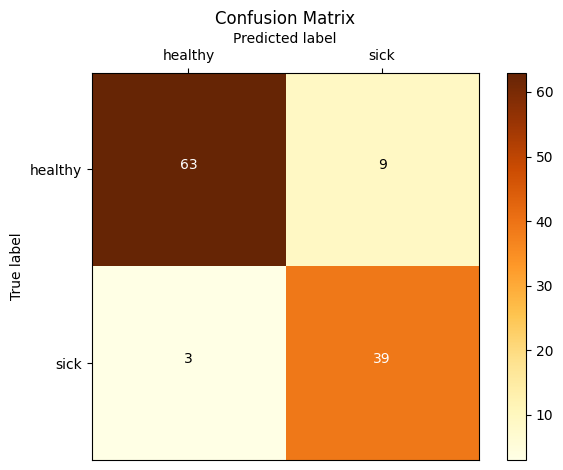

In [7]:
print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(target_test,predicted)))
print("Confusion Matrix: \n", metrics.confusion_matrix(target_test,predicted))
draw_confusion_matrix(target_test, predicted, ['healthy', 'sick'])

###  Parameters for Decision Tree Classifier

In Sci-kit Learn, the following are just some of the parameters we can pass into the Decision Tree Classifier:

- criterion: {‘gini’, ‘entropy’, ‘log_loss’} default="gini"
    - The function to measure the quality of a split. Supported criteria are “gini” for the Gini impurity and “log_loss” and “entropy” both for the Shannon information gain 
- splitter: {“best”, “random”}, default=”best”
    - The strategy used to choose the split at each node. “best” aims to find the best feature split amongst all features. "random" only looks for the best split amongst a random subset of features.
- max_depth: int, default = 2 {‘newton-cg’, ‘lbfgs’, ‘liblinear’, ‘sag’, ‘saga’}, default=’lbfgs’
    - The maximum depth of the tree.
- min_samples_split: int or float, default=2
    - The minimum number of samples required to split an internal node. If int, then consider min_samples_split as the minimum number. If float, then min_samples_split is a fraction and ceil(min_samples_split * n_samples) are the minimum number of samples for each split.

### Visualizing Decision Trees

Scikit-learn allows us to visualize the decision tree to see what features it choose to split and what the result is. Note that if the condition in the node is true, you traverse the left edge of the node. Otherwise, you traverse the right edge.

[Text(0.5, 0.8333333333333334, 'concave points_mean <= 0.011\ngini = 0.468\nsamples = 100.0%\nvalue = [0.626, 0.374]'),
 Text(0.25, 0.5, 'area_mean <= 0.124\ngini = 0.101\nsamples = 61.5%\nvalue = [0.946, 0.054]'),
 Text(0.125, 0.16666666666666666, '\n  (...)  \n'),
 Text(0.375, 0.16666666666666666, '\n  (...)  \n'),
 Text(0.75, 0.5, 'concavity_mean <= 0.001\ngini = 0.202\nsamples = 38.5%\nvalue = [0.114, 0.886]'),
 Text(0.625, 0.16666666666666666, '\n  (...)  \n'),
 Text(0.875, 0.16666666666666666, '\n  (...)  \n')]

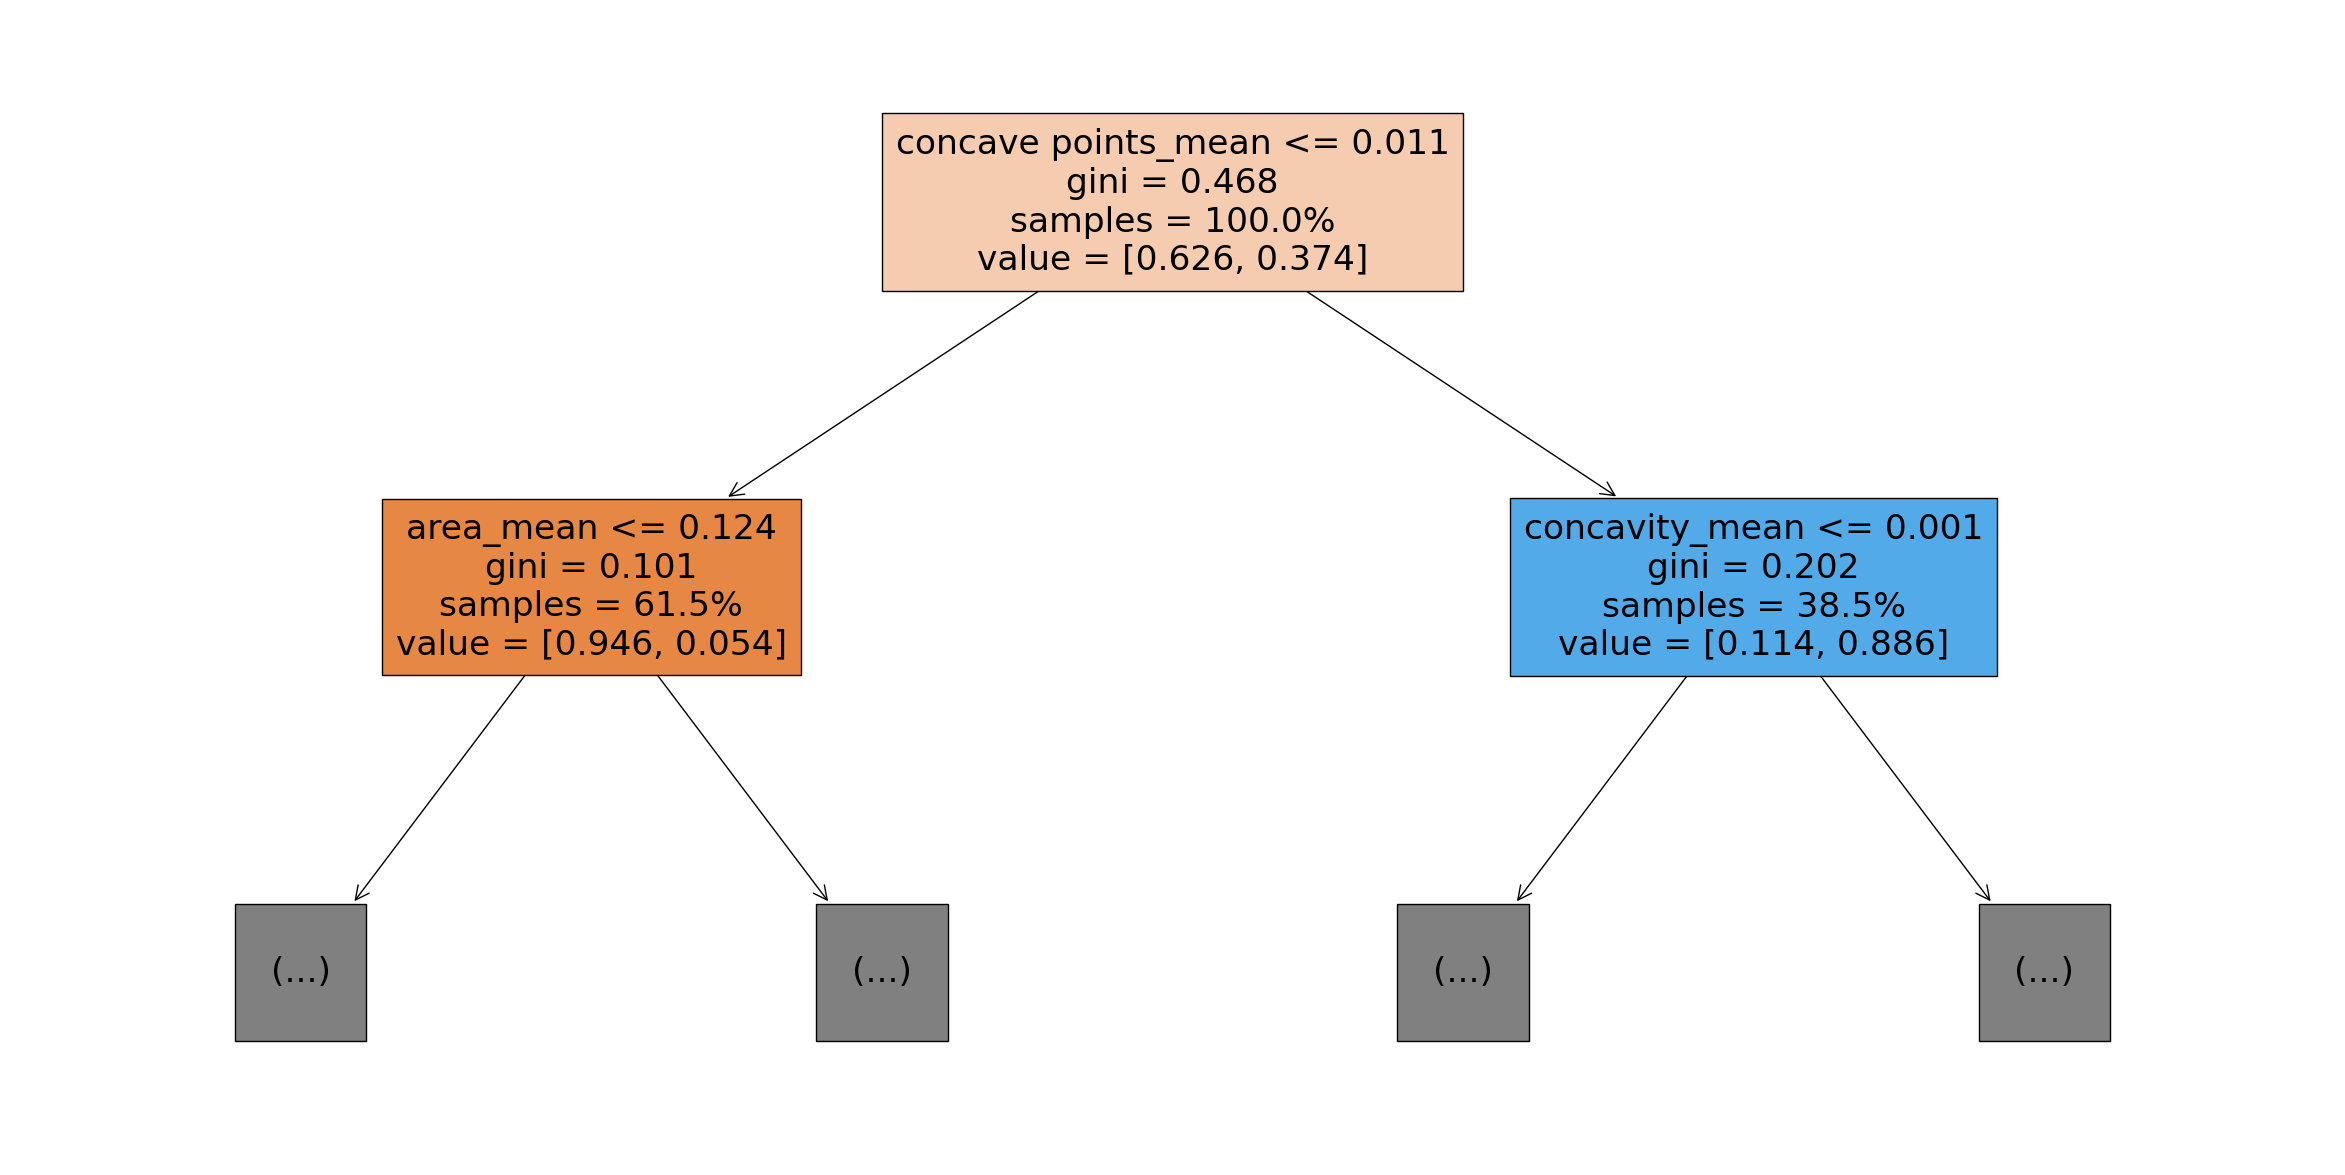

In [8]:
plt.figure(figsize = (30,15)) 
#Note that we have to pass the feature names into the plotting function to get the actual names
#We pass the column names through the pipeline in case any feature augmentation was made
#For example, a categorical feature will be split into multiple features with one hot encoding
#and this way assigns a name to each column based on the feature value and the original feature name
tree.plot_tree(clf,max_depth=1, proportion=True,feature_names=feature_names, filled=True)

We can even look at the tree in a textual format.

In [9]:
from sklearn.tree import export_text
r = export_text(clf, feature_names=feature_names)
print(r)

|--- concave points_mean <= 0.01
|   |--- area_mean <= 0.12
|   |   |--- area_se <= 0.04
|   |   |   |--- compactness_mean <= 0.59
|   |   |   |   |--- fractal_dimension_se <= -0.83
|   |   |   |   |   |--- fractal_dimension_se <= -0.84
|   |   |   |   |   |   |--- smoothness_se <= -1.22
|   |   |   |   |   |   |   |--- compactness_se <= -0.98
|   |   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |   |   |--- compactness_se >  -0.98
|   |   |   |   |   |   |   |   |--- class: 1
|   |   |   |   |   |   |--- smoothness_se >  -1.22
|   |   |   |   |   |   |   |--- class: 0
|   |   |   |   |   |--- fractal_dimension_se >  -0.84
|   |   |   |   |   |   |--- class: 1
|   |   |   |   |--- fractal_dimension_se >  -0.83
|   |   |   |   |   |--- class: 0
|   |   |   |--- compactness_mean >  0.59
|   |   |   |   |--- symmetry_se <= 0.20
|   |   |   |   |   |--- class: 1
|   |   |   |   |--- symmetry_se >  0.20
|   |   |   |   |   |--- class: 0
|   |   |--- area_se >  0.04
|   |   |   

### Feature Importance in Decision Trees

Decision Trees can also assign importance to features by measuring the average decrease in impurity (i.e. information gain) for each feature. The features with higher decreases are treated as more important. 

<AxesSubplot: >

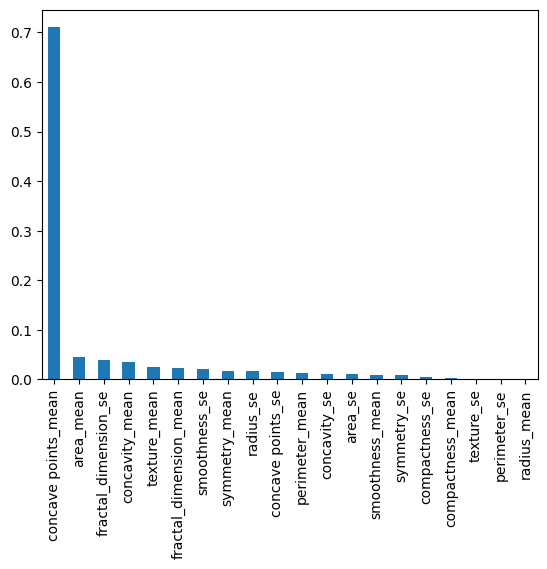

In [10]:
imp_pd = pd.Series(data = clf.feature_importances_ ,index = feature_names)
imp_pd= imp_pd.sort_values(ascending=False)
imp_pd.plot.bar()

We can clearly see that "concave points_mean" has the largest importance due to it providing the most reduction in the impurity.

### Visualizing decision boundaries for Decision Trees

Similar to project 2, lets see what decision boundaries that a Decision Tree creates. We use the two most correlated features to the target labels: concave_points_mean and perimeter_mean. 

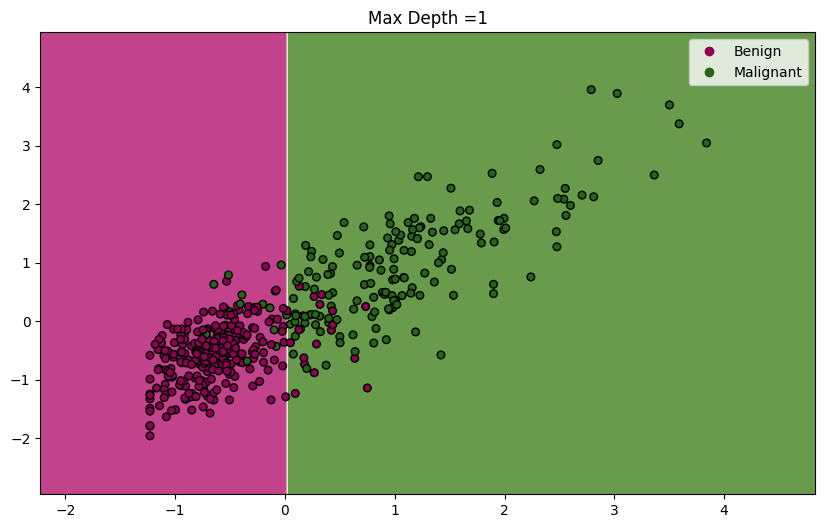

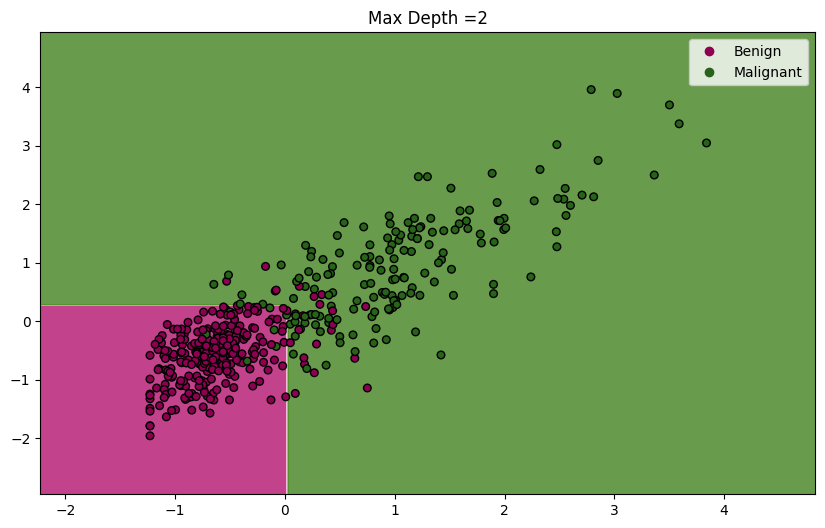

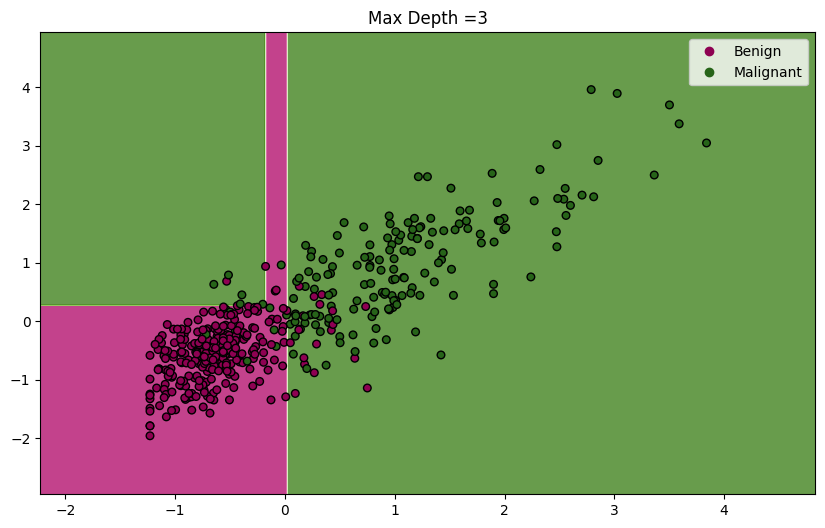

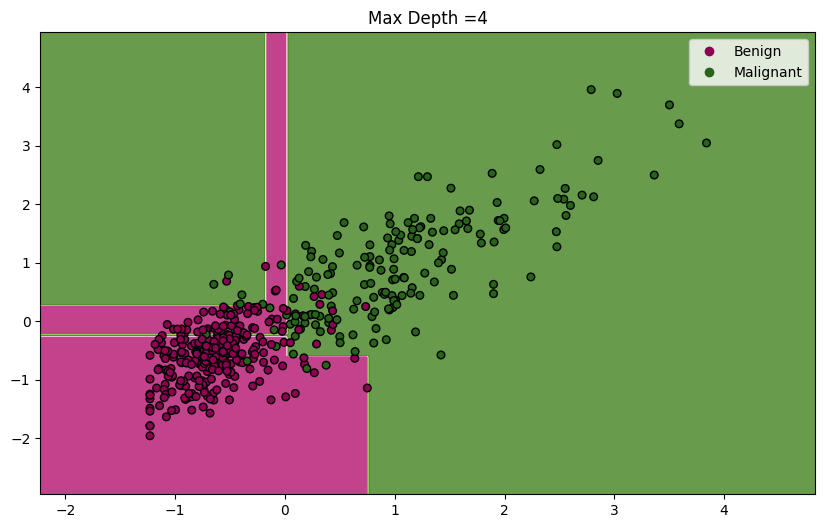

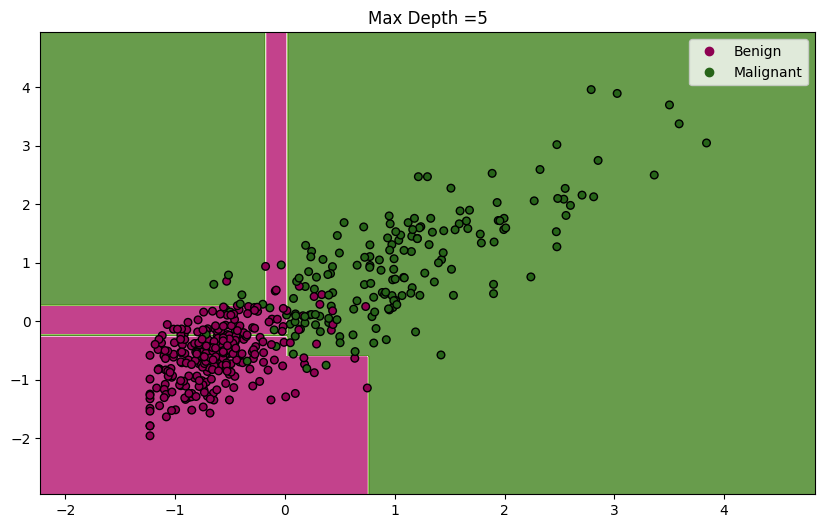

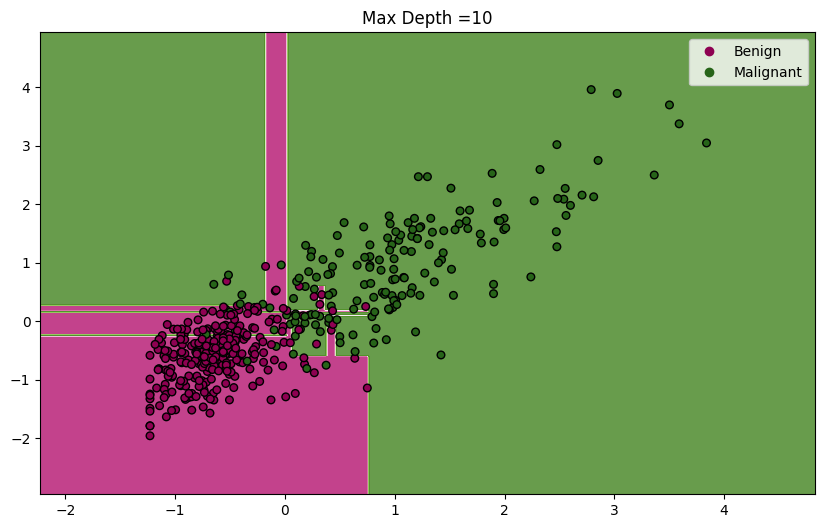

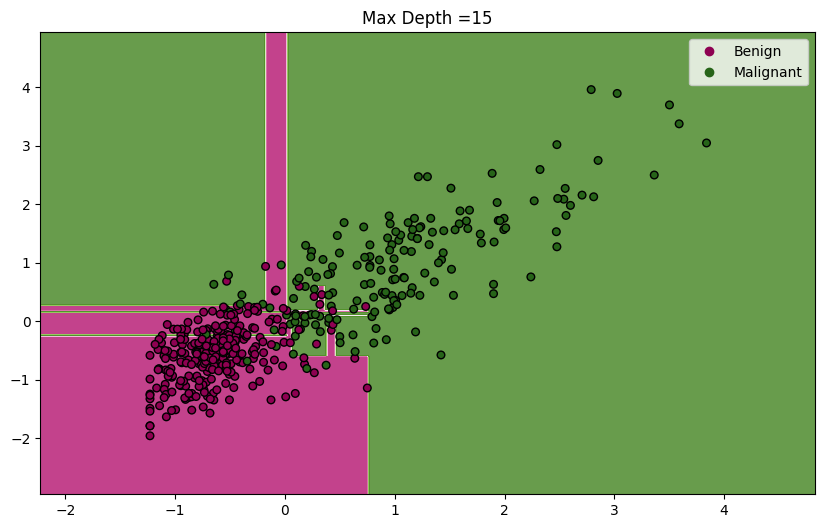

In [11]:
#Extract first two feature and use the standardscaler 
train_2 = StandardScaler().fit_transform(train_raw[['concave points_mean','perimeter_mean']])

depth  = [1,2,3,4,5,10,15]
for d in depth:
    dt = DecisionTreeClassifier(max_depth = d, min_samples_split=7) 
    dt.fit(train_2, target)
    draw_contour(train_2,target,dt,class_labels = ['Benign', 'Malignant'])
    
    plt.title(f"Max Depth ={d}")

We can see that the model gets more and more complex with increasing depth until it converges somewhere in between depth 10 and 15. 

## Supervised Learning: Multi-Layer Perceptron (MLP)

A neural network is a series of algorithms that endeavors to recognize underlying relationships in a set of data through a process that mimics the way the human brain operates. Neural networks are very powerful tools that are used a in a variety of applications including image and speech processing. In class, we have discussed one of the earliest types of neural networks known as a Multi-Layer Perceptron. 

![steps](jupyter_images/mlp_example.png)

### Using MLP for classification

In [12]:
from sklearn.neural_network import MLPClassifier
clf = MLPClassifier(hidden_layer_sizes=(100,), max_iter = 400)
clf.fit(train, target)
predicted = clf.predict(test)

/home/josh/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (400) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy:    0.929825
Confusion Matrix: 
 [[67  5]
 [ 3 39]]


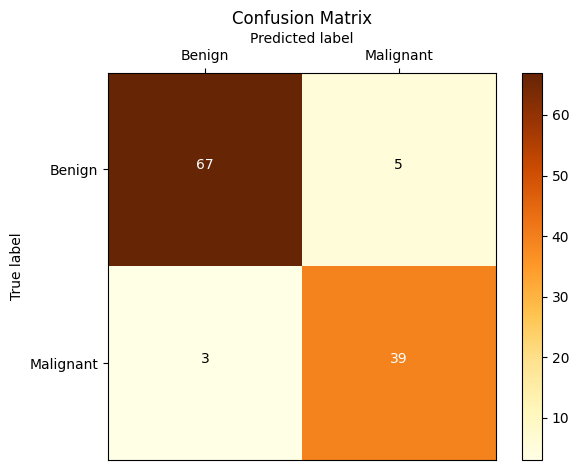

In [13]:
print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(target_test,predicted)))
print("Confusion Matrix: \n", metrics.confusion_matrix(target_test,predicted))
draw_confusion_matrix(target_test, predicted, ['Benign', 'Malignant'])

###  Parameters for MLP Classifier

In Sci-kit Learn, the following are just some of the parameters we can pass into MLP Classifier:

- hidden_layer_sizes: tuple, length = n_layers - 2, default=(100,)
    - The ith element represents the number of neurons in the ith hidden layer. 
- activation: {‘identity’, ‘logistic’, ‘tanh’, ‘relu’}, default=’relu’
    - Activation function for the hidden layer.
- alpha: float, default = 0.0001
    - Strength of the L2 regularization term. The L2 regularization term is divided by the sample size when added to the loss.
- max_iter: int, default=200
    - Maximum number of iterations taken for the solvers to converge.

### Visualizing decision boundaries for MLP

Now, lets see how the decision boundaries change as a function of both the activation function and the number of hidden layers.

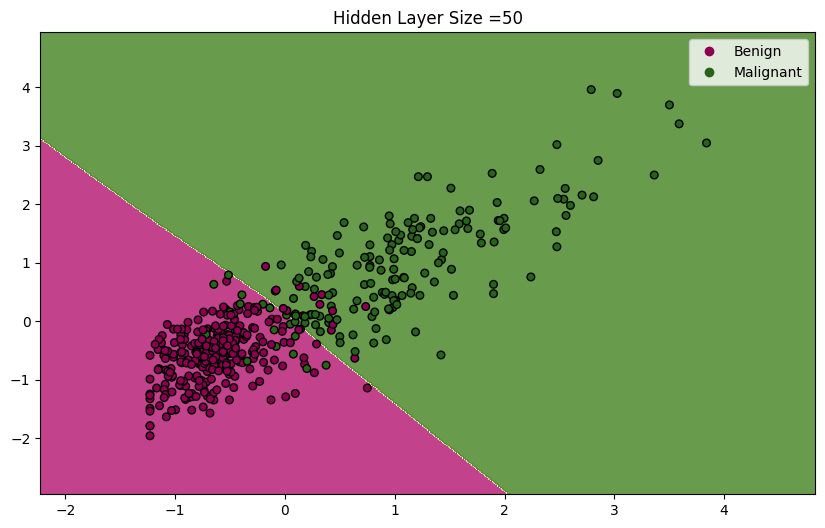

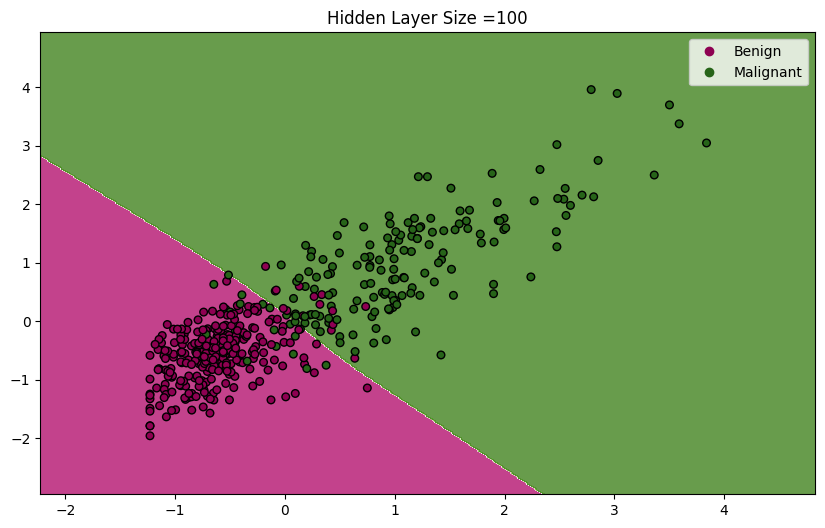

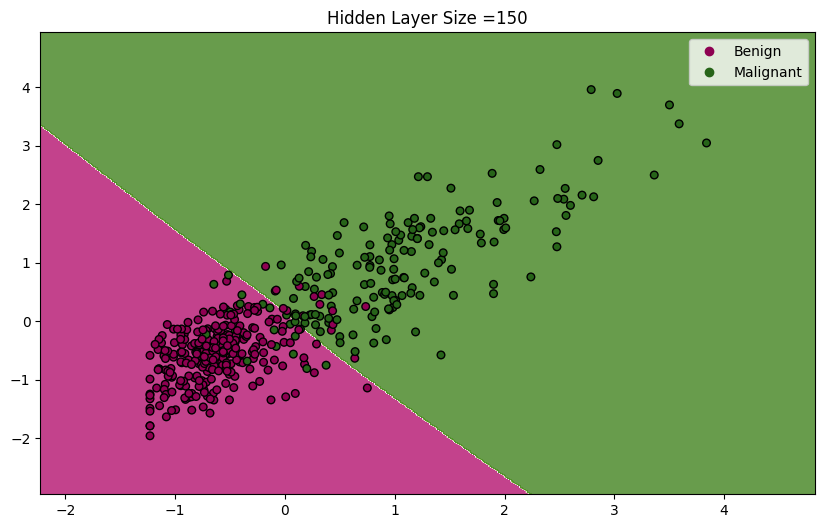

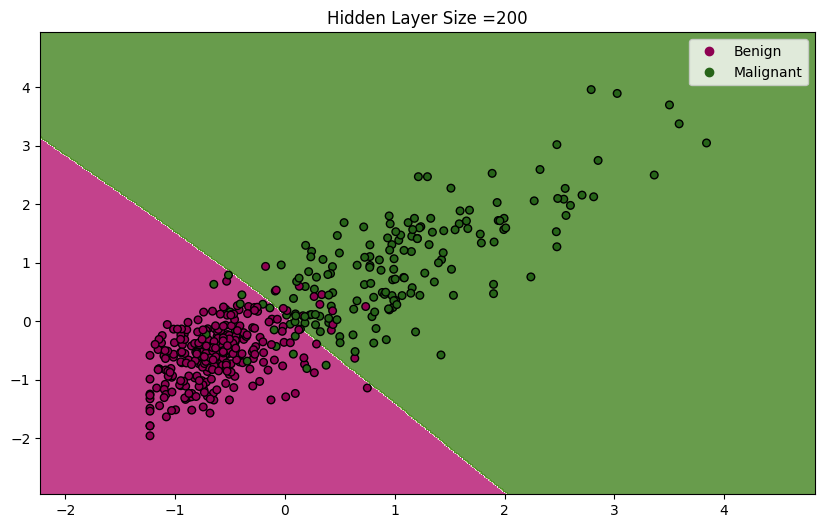

In [14]:
#Example of using the default Relu activation while altering the number of hidden layers
train_2 = StandardScaler().fit_transform(train_raw[['concave points_mean','perimeter_mean']])

layers  = [50,100,150,200]
for l in layers:
    mlp = MLPClassifier(hidden_layer_sizes=(l,), max_iter = 400)
    mlp.fit(train_2, target)
    draw_contour(train_2,target,mlp,class_labels = ['Benign', 'Malignant'])
    
    plt.title(f"Hidden Layer Size ={l}")

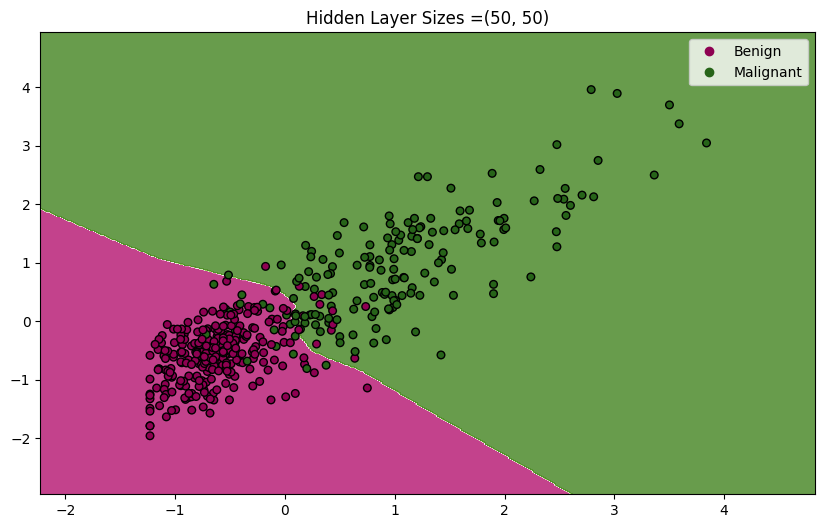

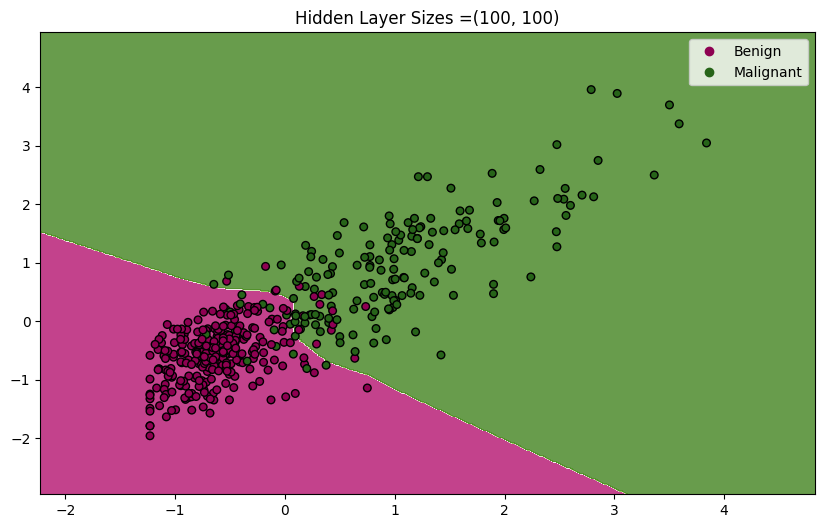

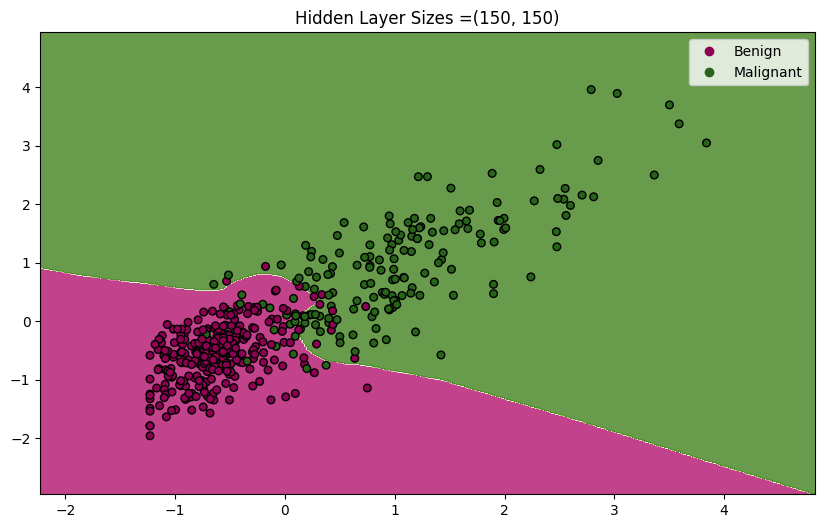

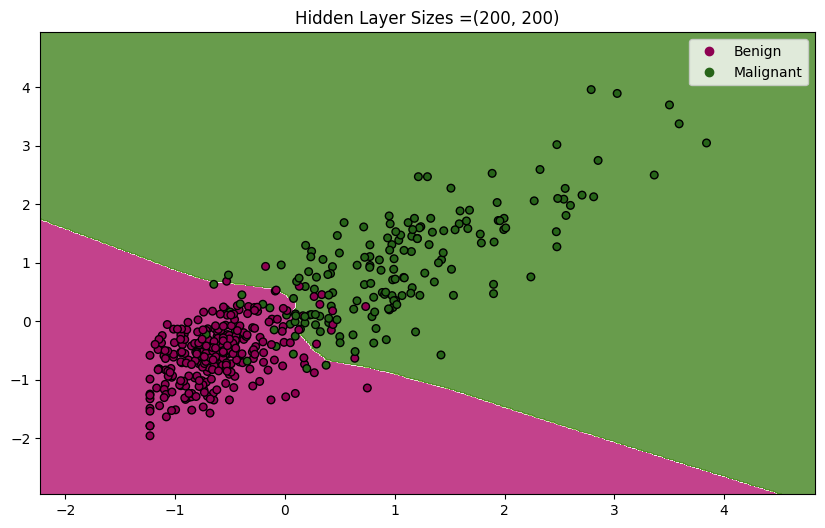

In [15]:
#Example of using the default Relu activation 
#while altering the number of hidden layers with 2 groups of hidden layers
train_2 = StandardScaler().fit_transform(train_raw[['concave points_mean','perimeter_mean']])

layers  = [50,100,150,200]
for l in layers:
    mlp = MLPClassifier(hidden_layer_sizes=(l,l), max_iter = 400)
    mlp.fit(train_2, target)
    draw_contour(train_2,target,mlp,class_labels = ['Benign', 'Malignant'])
    
    plt.title(f"Hidden Layer Sizes ={(l,l)}")

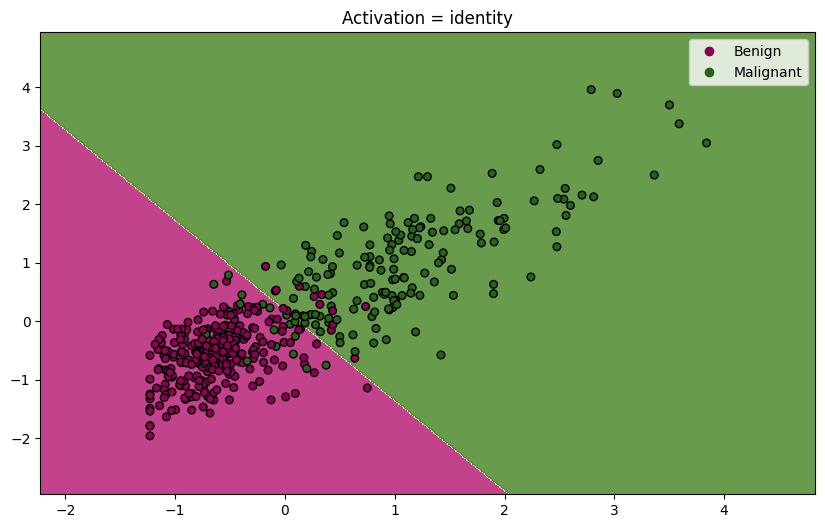

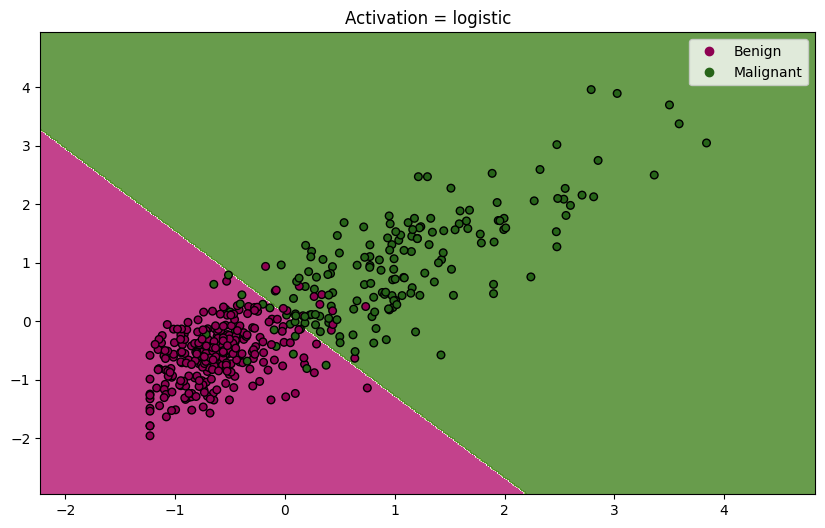

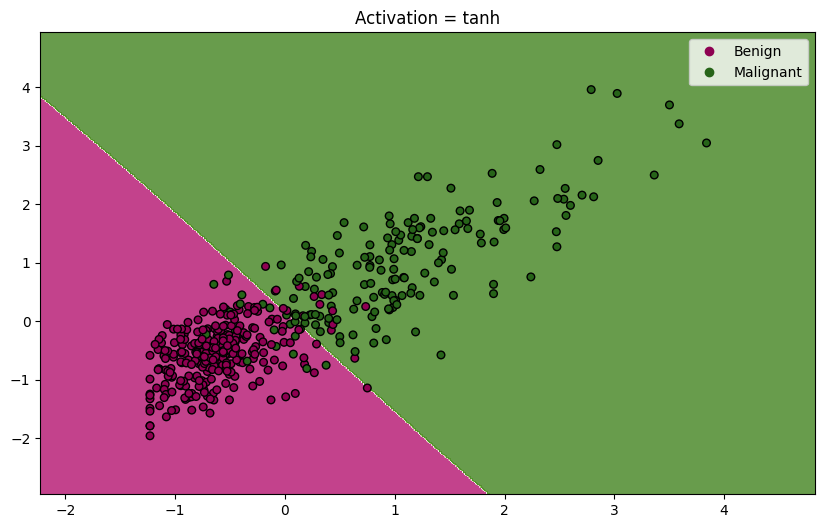

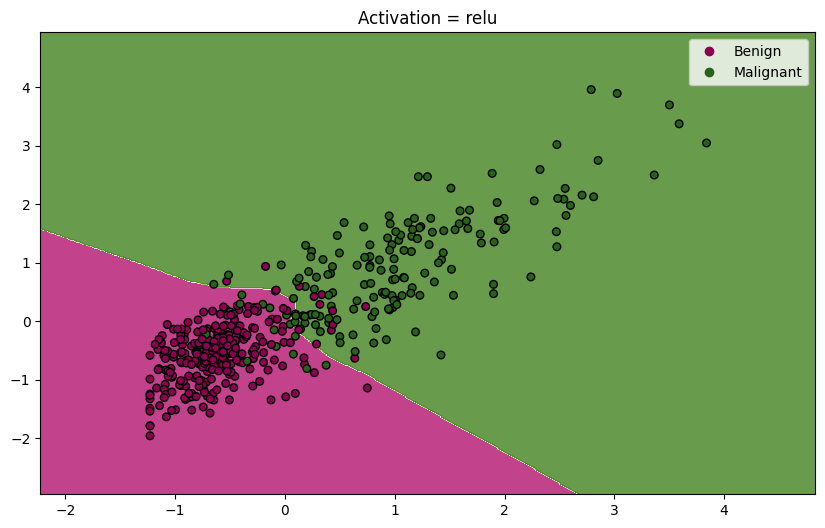

In [16]:
#Example of using 2 hidden layers of 100 units each with varying activations
train_2 = StandardScaler().fit_transform(train_raw[['concave points_mean','perimeter_mean']])

acts  = ['identity', 'logistic', 'tanh', 'relu']
for act in acts:
    mlp = MLPClassifier(hidden_layer_sizes=(100,100), activation = act, max_iter = 400)
    mlp.fit(train_2, target)
    draw_contour(train_2,target,mlp,class_labels = ['Benign', 'Malignant'])
    
    plt.title(f"Activation = {act}")

## Unsupervised learning: PCA

As shown in lecture, PCA is a valuable dimensionality reduction tool that can extract a small subset of valuable features. In this section, we shall demonstrate how PCA can extract important visual features from pictures of subjects faces. We shall use the [AT&T Database of Faces](https://www.kaggle.com/datasets/kasikrit/att-database-of-faces). This dataset contains 40 different subjects with 10 samples per subject which means we a dataset of 400 samples. 

We extract the images from the [scikit-learn dataset library](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.fetch_olivetti_faces.html#sklearn.datasets.fetch_olivetti_faces). The library imports the images (faces.data), the flatten array of images (faces.images), and which subject eacj image belongs to (faces.target). Each image is a 64 by 64 image with pixels converted to floating point values in [0,1].

### Eigenfaces

The following codes downloads and loads the face data. 

In [17]:
#Import faces from scikit library
faces = datasets.fetch_olivetti_faces()
print("Flattened Face Data shape:", faces.data.shape)
print("Face Image Data Shape:", faces.images.shape)
print("Shape of target data:", faces.target.shape)


Flattened Face Data shape: (400, 4096)
Face Image Data Shape: (400, 64, 64)
Shape of target data: (400,)


In [18]:
#Extract image shape for future use
im_shape = faces.images[0].shape

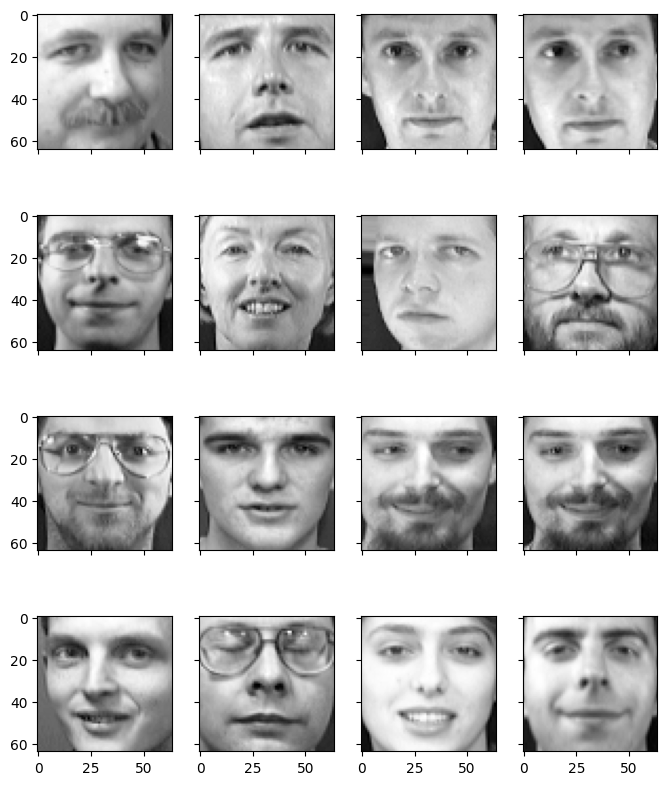

In [19]:
#Prints some example faces 
faceimages = faces.images[np.random.choice(len(faces.images),size= 16, replace = False)] # take random 16 images

fig, axes = plt.subplots(4,4,sharex=True,sharey=True,figsize=(8,10))
for i in range(16):
    axes[i%4][i//4].imshow(faceimages[i], cmap="gray")
plt.show()

Now, let us see what features we can extract from these face images.

In [20]:
#Perform PCA
from sklearn.decomposition import PCA
 
pca = PCA()
pca_pipe = Pipeline([("scaler",StandardScaler()), #Scikit learn PCA does not standardize so we need to add
               ("pca",pca)])
pca_pipe.fit(faces.data)

Pipeline(steps=[('scaler', StandardScaler()), ('pca', PCA())])

The following plots the top 30 PCA components with how much variance does this feature explain.

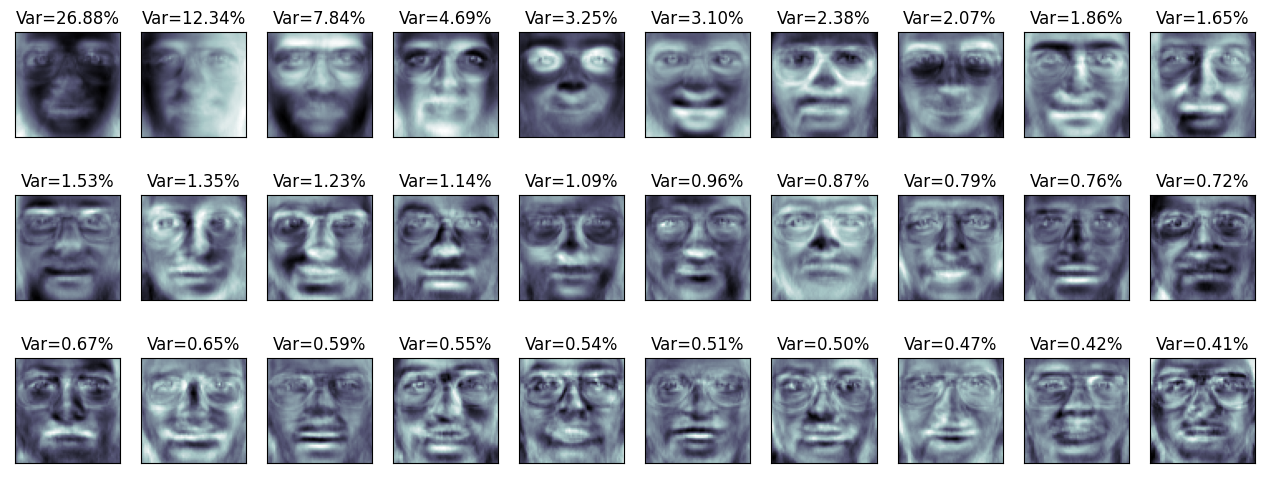

In [21]:
fig = plt.figure(figsize=(16, 6))
for i in range(30):
    ax = fig.add_subplot(3, 10, i + 1, xticks=[], yticks=[])
    ax.imshow(pca.components_[i].reshape(im_shape),
              cmap=plt.cm.bone)
    ax.set_title(f"Var={pca.explained_variance_ratio_[i]:.2%}")

Amazing! We can see that the model has learned to focus on many features that we as humans also look at when trying to identify a face such as the nose,eyes, eyebrows, etc.

With this feature extraction, we can perform much more powerful learning. 

### Feature Extraction for Classification

Lets see if we can use PCA to improve the accuracy of the decision tree classifier.

Accuracy without PCA
Accuracy:    0.894737
Confusion Matrix: 
 [[63  9]
 [ 3 39]]


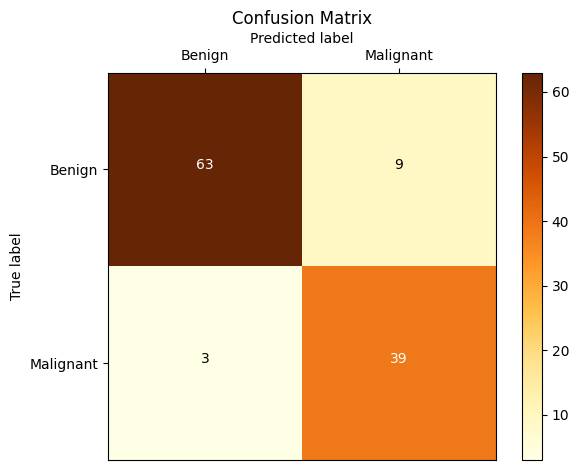

Accuracy with PCA
Accuracy:    0.912281
Confusion Matrix: 
 [[66  6]
 [ 4 38]]


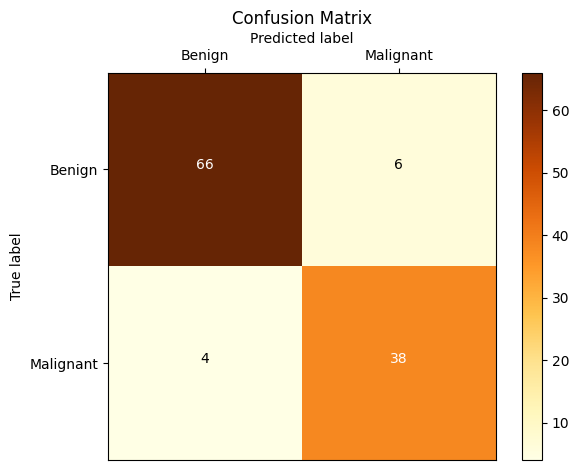

In [22]:
#Without PCA
clf = DecisionTreeClassifier(random_state=0)
clf.fit(train, target)
predicted = clf.predict(test)

print("Accuracy without PCA")
print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(target_test,predicted)))
print("Confusion Matrix: \n", metrics.confusion_matrix(target_test,predicted))
draw_confusion_matrix(target_test, predicted, ['Benign', 'Malignant'])

#With PCA
pca = PCA(n_components = 0.9) #Take components that explain at lest 90% variance
       
train_new = pca.fit_transform(train)
test_new = pca.transform(test)

clf_pca = DecisionTreeClassifier(random_state=0)
clf_pca.fit(train_new, target)
predicted = clf_pca.predict(test_new)

print("Accuracy with PCA")
print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(target_test,predicted)))
print("Confusion Matrix: \n", metrics.confusion_matrix(target_test,predicted))
draw_confusion_matrix(target_test, predicted, ['Benign', 'Malignant'])

In [23]:
print("Number of Features without PCA: ", train.shape[1])
print("Number of Features with PCA: ", train_new.shape[1])

Number of Features without PCA:  20
Number of Features with PCA:  7


Clearly, we get a much better accuracy for the model while using fewer features. But does the features the PCA thought were important the same features that the decision tree used. Lets look at the feature importance of the tree. The following plot numbers the first principal component as 0, the second as 1, and so forth.

<AxesSubplot: >

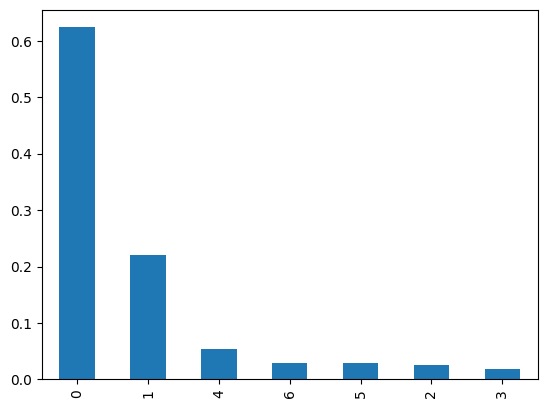

In [24]:
feature_names_new = list(range(train_new.shape[1]))
imp_pd = pd.Series(data = clf_pca.feature_importances_ ,index = feature_names_new)
imp_pd= imp_pd.sort_values(ascending=False)
imp_pd.plot.bar()

Amazingly, the first and second components were the most important features in the decision tree. Thus, we can claim that PCA has significantly improved the performance of our model. 

## Unsupervised learning: Clustering

Clustering is the task of grouping a set of objects in such a way that objects in the same group (called a cluster) are more similar (in some sense) to each other than to those in other groups. One major algorithm we learned in class is the K-Means algorithm.

### Evaluating K-Means performance

While there are many ways to evaluate the [performance measure of clustering algorithsm](https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation), we will focus on the inertia score of the K-Means model. Inertia is another term for the sum of squared distances of samples to their closest cluster center. 

Let us look at how the Inertia changes as a function of the number of clusters for an artificial dataset.


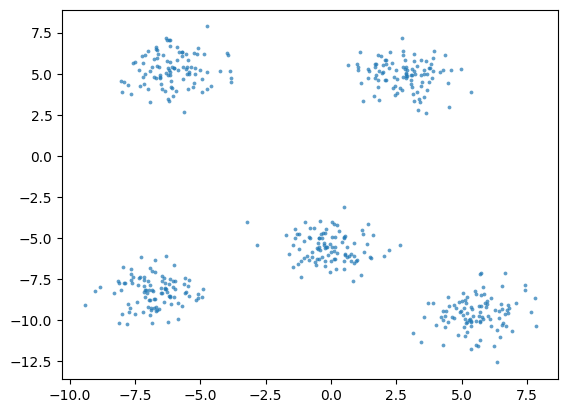

In [25]:
#Artifical Dataset
X, y = make_blobs(
    n_samples=500,
    n_features=2,
    centers=5,
    cluster_std=1,
    center_box=(-10.0, 10.0),
    shuffle=True,
    random_state=10,
)  # For reproducibility

plt.scatter(X[:, 0], X[:, 1], marker=".", s=30, lw=0, alpha=0.7,edgecolor="k")

In [26]:
ks = list(range(2,10))
inertia = []
for k in ks:
    kmeans = KMeans(n_clusters = k, init = 'k-means++', random_state = 0)
    kmeans.fit(X)
    # inertia method returns wcss for that model
    inertia.append(kmeans.inertia_)
    print(f"Inertia for K = {k}: {kmeans.inertia_}")

Inertia for K = 2: 13293.997460961542
Inertia for K = 3: 7169.578996856776
Inertia for K = 4: 3247.867404069585
Inertia for K = 5: 872.8554968701874
Inertia for K = 6: 803.8466864258223
Inertia for K = 7: 739.5236191503769
Inertia for K = 8: 690.2530283275601
Inertia for K = 9: 614.5138307338651


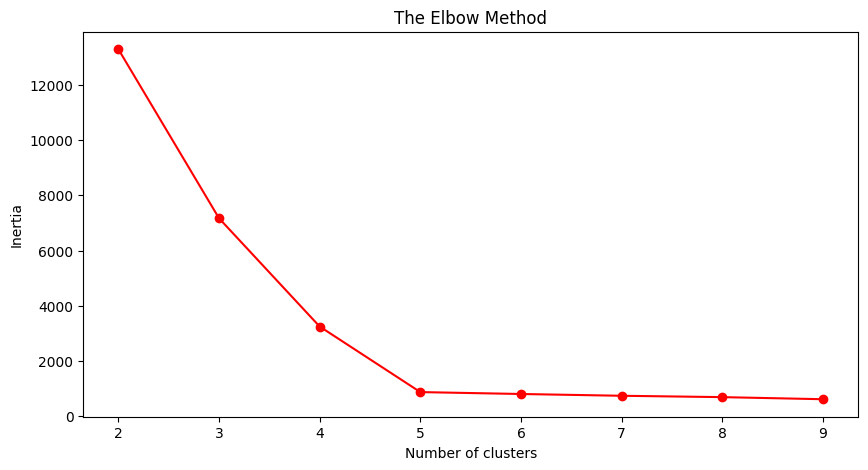

In [27]:
plt.figure(figsize=(10,5))
plt.plot(ks, inertia,marker='o',color='red')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

From the plot, we can see that when the number of clusters of K-means is the correct number of clusters, Inertia starts decreasing at a much slower rate. This creates a kind of elbow shape in the graph. For K-means clustering, the elbow method selects the number of clusters where the elbow shape is formed. In this case, we see that this method would produce the correct number of clusters.

Lets try it on the cancer dataset.

In [28]:
ks = list(range(2,30))
inertia = []
for k in ks:
    kmeans = KMeans(n_clusters = k, init = 'k-means++', random_state = 0)
    kmeans.fit(train)
    # inertia method returns wcss for that model
    inertia.append(kmeans.inertia_)
    print(f"Inertia for K = {k}: {kmeans.inertia_}")

Inertia for K = 2: 6381.278325955918
Inertia for K = 3: 5508.62144659371
Inertia for K = 4: 4972.2317219731185
Inertia for K = 5: 4507.2671373660705
Inertia for K = 6: 4203.777246823877
Inertia for K = 7: 3942.659550896413
Inertia for K = 8: 3745.112422829267
Inertia for K = 9: 3532.722515602207
Inertia for K = 10: 3371.0334670278367
Inertia for K = 11: 3232.472758070738
Inertia for K = 12: 3135.1944201924525
Inertia for K = 13: 3033.383842778647
Inertia for K = 14: 2958.320003636036
Inertia for K = 15: 2893.7987635119043
Inertia for K = 16: 2767.804761705545
Inertia for K = 17: 2737.4747101790626
Inertia for K = 18: 2662.1203080706646
Inertia for K = 19: 2617.9089069400507
Inertia for K = 20: 2553.961378449724
Inertia for K = 21: 2491.9133737078337
Inertia for K = 22: 2448.777623600996
Inertia for K = 23: 2391.644588540416
Inertia for K = 24: 2374.1345787190166
Inertia for K = 25: 2334.7940109810725
Inertia for K = 26: 2267.993521706617
Inertia for K = 27: 2233.5854532391295
Inertia f

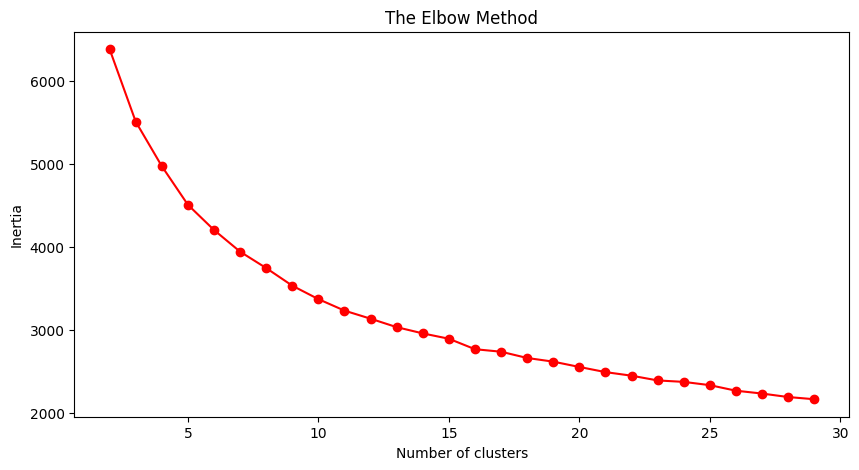

In [29]:
plt.figure(figsize=(10,5))
plt.plot(ks, inertia,marker='o',color='red')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

Here we see that the elbow is not as cleanly defined. This may be due to the dataset not being a good fit for K-means. Regardless, we can still apply the elbow method by noting that the slow down happens around 7~14.

### Kmeans on Eigenfaces

Now, lets see how K-means performs in clustering the face data with PCA.

In [30]:
from sklearn.cluster import KMeans

n_clusters = 10 #We know there are 10 subjects
km = KMeans(n_clusters  = n_clusters,random_state=0)

pipe= Pipeline([("scaler",StandardScaler()), #First standardize
               ("pca",PCA()), #Transform using pca
         ("kmeans", km )]) #Then apply k means

In [31]:
clusters = pipe.fit_predict(faces.data)
print(clusters)

[3 6 3 4 6 4 3 3 3 6 5 5 5 5 5 5 5 5 5 5 1 1 5 1 4 1 4 4 6 6 5 5 5 3 6 4 3
 5 5 6 4 1 1 4 4 4 4 4 4 3 3 3 3 3 3 3 3 3 3 3 7 7 3 4 7 3 7 7 3 7 0 6 3 6
 3 3 6 3 3 6 1 1 1 4 4 4 4 4 1 6 6 6 6 6 6 6 6 6 4 3 0 0 0 0 0 0 0 0 0 0 4
 1 1 1 1 4 1 6 6 4 5 5 4 4 5 5 4 4 5 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5
 5 5 8 3 3 3 3 8 6 8 3 3 4 4 1 1 4 4 4 4 4 4 3 6 4 6 3 3 3 3 3 3 7 7 7 7 7
 7 7 7 7 7 9 9 9 4 4 4 4 4 4 9 9 9 9 9 9 9 4 8 9 4 2 2 2 2 2 2 2 2 2 2 3 6
 1 4 1 4 1 6 4 4 8 8 8 8 5 8 8 8 8 8 6 5 6 5 5 5 6 4 5 6 1 1 1 1 1 1 3 1 1
 5 5 5 5 5 5 5 5 5 5 5 5 1 5 5 5 5 5 5 1 4 2 2 2 9 4 4 9 8 2 2 9 9 9 9 9 9
 9 9 9 9 9 9 9 9 9 9 9 9 9 9 7 7 7 7 7 7 5 7 7 7 9 9 9 9 9 9 9 9 9 9 2 2 2
 2 2 2 2 2 2 2 9 9 9 9 4 6 6 1 4 4 3 8 8 8 7 8 8 8 8 8 1 1 1 1 1 1 1 1 1 1
 4 1 1 6 1 4 6 6 4 1 2 2 2 2 2 2 2 2 2 2 6 4 3 4 3 1 4 1 4 4]


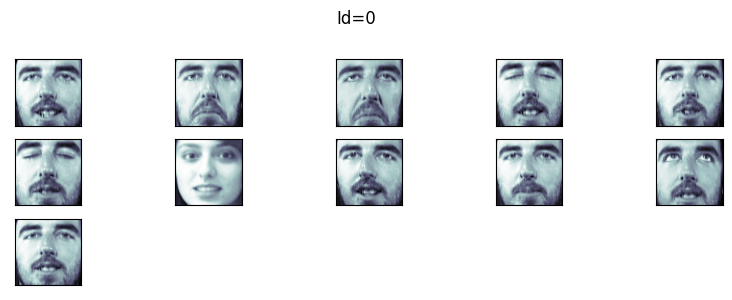

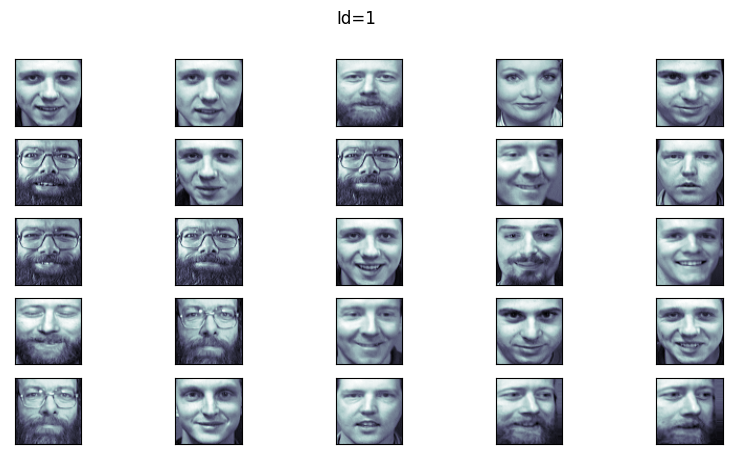

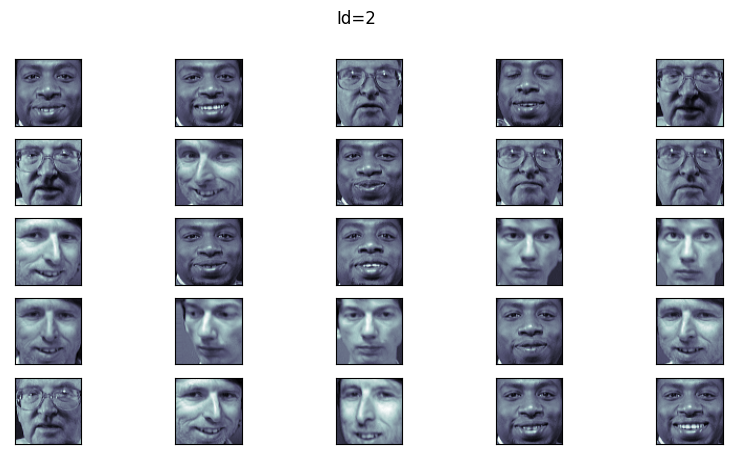

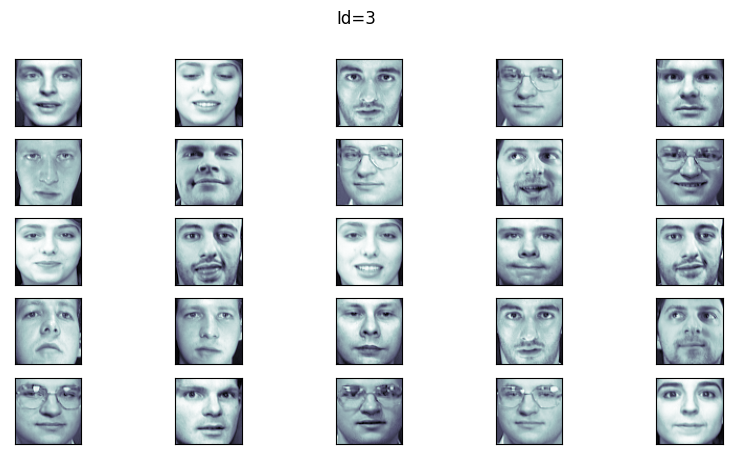

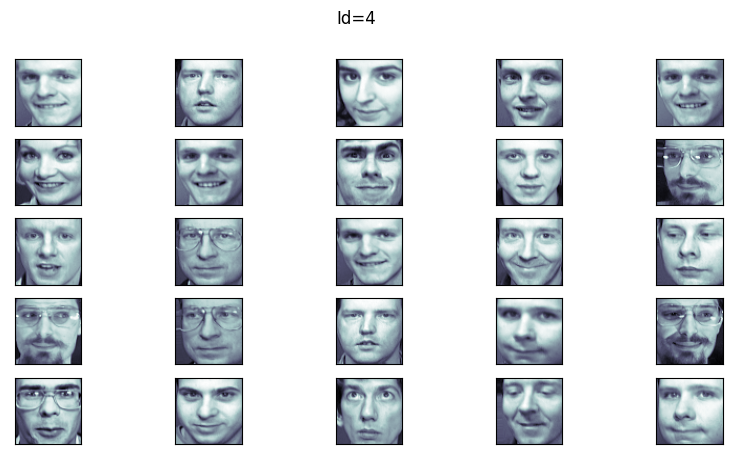

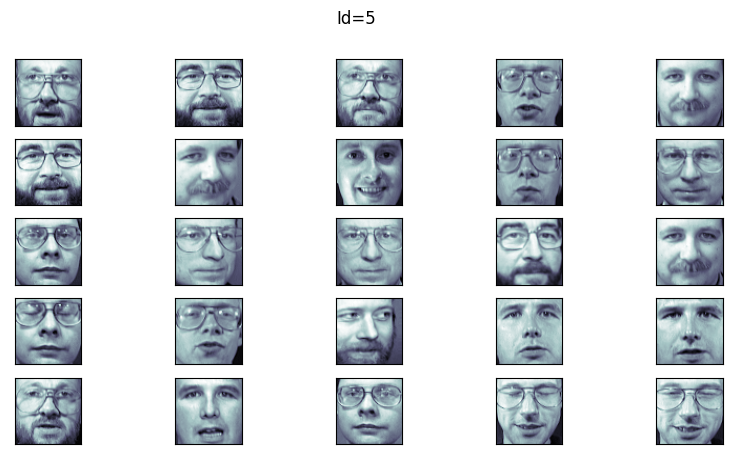

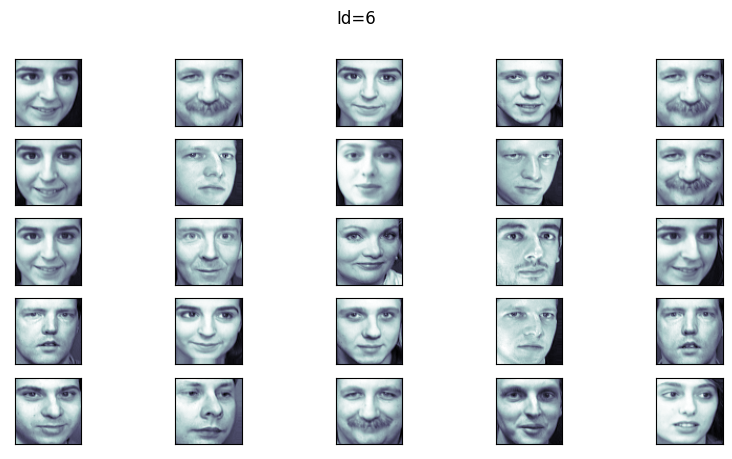

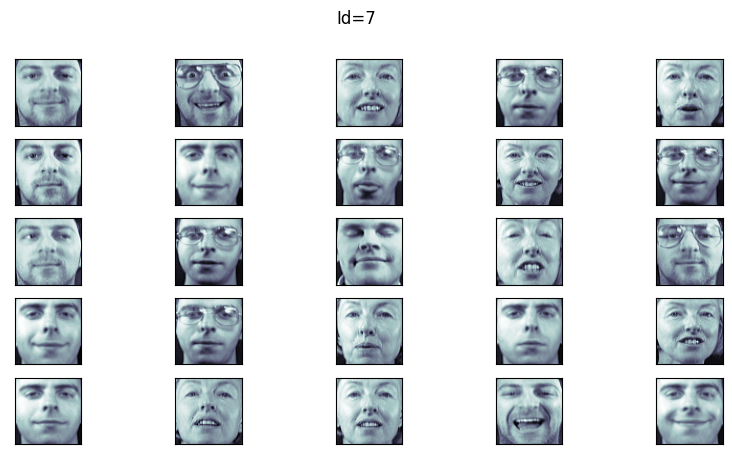

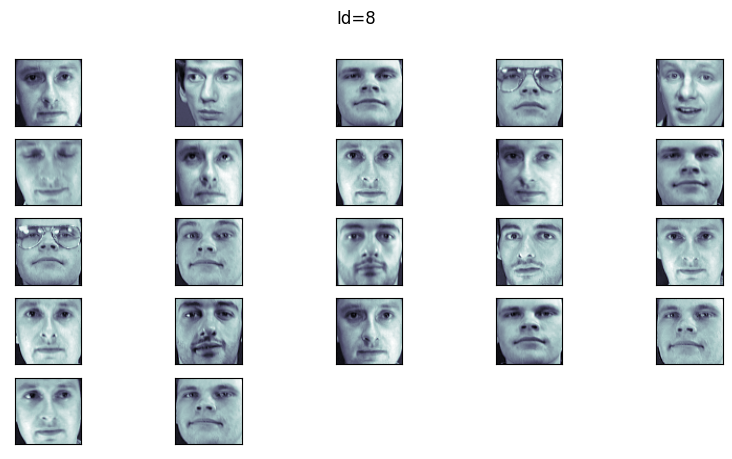

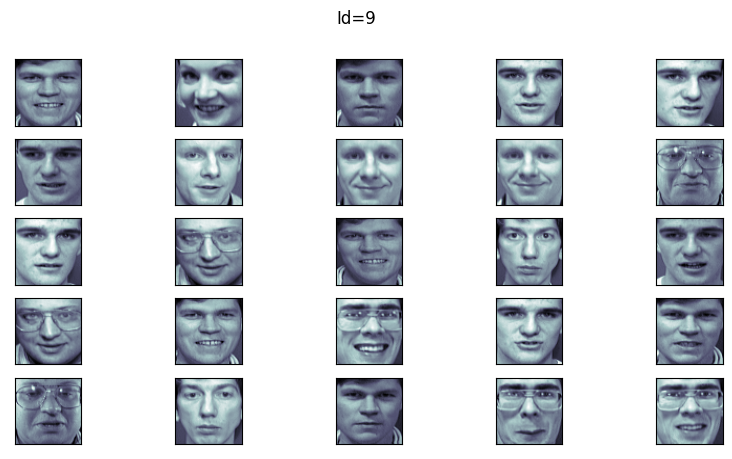

In [32]:
for labelID in range(n_clusters):
    # find all indexes into the `data` array that belong to the
    # current label ID, then randomly sample a maximum of 25 indexes
    # from the set
    idxs = np.where(clusters == labelID)[0]
    idxs = np.random.choice(idxs, size=min(25, len(idxs)),
        replace=False)

    # Extract the sampled indexes
    id_face = faces.images[idxs]

    #Plots sampled faces
    fig = plt.figure(figsize=(10,5))
    for i in range(min(25,len(idxs))):
        ax = fig.add_subplot(5, 5, i + 1, xticks=[], yticks=[])
        ax.imshow(id_face[i],
                  cmap=plt.cm.bone)
    fig.suptitle(f"Id={labelID}")

While the algorithm isn't perfect, we can see that K-means with PCA is picking up on some facial similarity or similar expressions. 

# (100 pts) Todo: Use new methods to classify heart disease

To compare how these new models perform with the other models discussed in the course, we will apply these new models on the heart disease dataset that was used in project 2.

## Background: The Dataset (Recap)

For this exercise we will be using a subset of the UCI Heart Disease dataset, leveraging the fourteen most commonly used attributes. All identifying information about the patient has been scrubbed. You will be asked to classify whether a <b>patient is suffering from heart disease</b> based on a host of potential medical factors.

The dataset includes 14 columns. The information provided by each column is as follows:
<ul>
    <li><b>age:</b> Age in years</li>
    <li><b>sex:</b> (1 = male; 0 = female)</li>
    <li><b>cp:</b> Chest pain type (0 = asymptomatic; 1 = atypical angina; 2 = non-anginal pain; 3 = typical angina)</li>
    <li><b>trestbps:</b> Resting blood pressure (in mm Hg on admission to the hospital)</li>
    <li><b>chol:</b> cholesterol in mg/dl</li>
    <li><b>fbs</b> Fasting blood sugar > 120 mg/dl (1 = true; 0 = false)</li>
    <li><b>restecg:</b> Resting electrocardiographic results (0= showing probable or definite left ventricular hypertrophy by Estes' criteria; 1 = normal; 2 = having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV))</li>
    <li><b>thalach:</b> Maximum heart rate achieved</li>
    <li><b>exang:</b> Exercise induced angina (1 = yes; 0 = no)</li>
    <li><b>oldpeak:</b> Depression induced by exercise relative to rest</li>
    <li><b>slope:</b> The slope of the peak exercise ST segment (0 = downsloping; 1 = flat; 2 = upsloping)</li>
    <li><b>ca:</b> Number of major vessels (0-3) colored by flourosopy</li>
    <li><b>thal:</b> 1 = normal; 2 = fixed defect; 7 = reversable defect</li>
    <li><b><u>sick:</u></b> Indicates the presence of Heart disease (True = Disease; False = No disease)</li>
</ul>
    

## Preprocess Data

This part is done for you since you would have already completed it in project 2. Use the train, target, test, and target_test for all future parts. We also provide the column names for each transformed column for future use.

In [33]:
#Preprocess Data

#Load Data
data = pd.read_csv('datasets/heartdisease.csv')

#Transform target feature into numerical
le = LabelEncoder() 
data['target'] = le.fit_transform(data['sick'])
data = data.drop(["sick"], axis =1)

#Split target and data
y = data["target"]
x = data.drop(["target"],axis = 1)

#Train test split
#40% in test data as was in project 2
train_raw, test_raw, target, target_test = train_test_split(x,y, test_size=0.4, stratify= y, random_state=0)

#Feature Transformation
#This is the only change from project 2 since we replaced standard scaler to minmax
#This was done to ensure that the numerical features were still of the same scale
#as the one hot encoded features
num_pipeline = Pipeline([
    ('minmax', MinMaxScaler()) 
])

heart_num = train_raw.drop(['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca','thal'], axis=1)
numerical_features = list(heart_num)
categorical_features = ['sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'ca','thal']

full_pipeline = ColumnTransformer([
    ("num", num_pipeline, numerical_features),
    ("cat", OneHotEncoder(categories='auto'), categorical_features),
])

#Transform raw data 
train = full_pipeline.fit_transform(train_raw)
test = full_pipeline.transform(test_raw) #Note that there is no fit calls

#Extracts features names for each transformed column
feature_names = full_pipeline.get_feature_names_out(list(x.columns))

In [34]:
print("Column names after transformation by pipeline: ", feature_names)

Column names after transformation by pipeline:  ['num__age' 'num__trestbps' 'num__chol' 'num__thalach' 'num__oldpeak'
 'cat__sex_0' 'cat__sex_1' 'cat__cp_0' 'cat__cp_1' 'cat__cp_2' 'cat__cp_3'
 'cat__fbs_0' 'cat__fbs_1' 'cat__restecg_0' 'cat__restecg_1'
 'cat__restecg_2' 'cat__exang_0' 'cat__exang_1' 'cat__slope_0'
 'cat__slope_1' 'cat__slope_2' 'cat__ca_0' 'cat__ca_1' 'cat__ca_2'
 'cat__ca_3' 'cat__ca_4' 'cat__thal_0' 'cat__thal_1' 'cat__thal_2'
 'cat__thal_3']


The following shows the baseline accuracy of simply classifying every sample as the majority class.

In [35]:
#Baseline accuracy of using the majority class 
ct = target_test.value_counts()
print("Counts of each class in target_test: ")
print(ct)
print("Baseline Accuraccy of using Majority Class: ", np.max(ct)/np.sum(ct))

Counts of each class in target_test: 
0    66
1    56
Name: target, dtype: int64
Baseline Accuraccy of using Majority Class:  0.5409836065573771


## (25 pts) Decision Trees

### [5 pts] Apply  Decision Tree on Train Data

Apply the decision tree on the **train data** with default parameters of the DecisionTreeClassifier. **Report the accuracy and print the confusion matrix**. Make sure to use random_state = 0 so that your results match ours.

Accuracy:    0.696721
Confusion Matrix: 
 [[53 13]
 [24 32]]


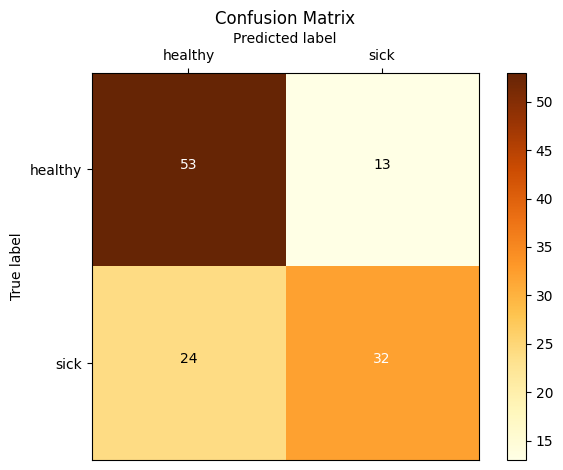

In [36]:
clf = DecisionTreeClassifier(criterion="gini", random_state = 0)
clf.fit(train, target)
predicted = clf.predict(test)
print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(target_test,predicted)))
print("Confusion Matrix: \n", metrics.confusion_matrix(target_test,predicted))
draw_confusion_matrix(target_test, predicted, ['healthy', 'sick'])

### [5 pts] Visualize the Decision Tree

Visualize the first two layers of the decision tree that you trained.

[Text(0.4230769230769231, 0.875, 'cat__cp_0 <= 0.5\ngini = 0.496\nsamples = 100.0%\nvalue = [0.547, 0.453]'),
 Text(0.15384615384615385, 0.625, 'num__chol <= 0.223\ngini = 0.283\nsamples = 48.6%\nvalue = [0.83, 0.17]'),
 Text(0.07692307692307693, 0.375, 'gini = 0.0\nsamples = 18.2%\nvalue = [1.0, 0.0]'),
 Text(0.23076923076923078, 0.375, 'cat__slope_2 <= 0.5\ngini = 0.397\nsamples = 30.4%\nvalue = [0.727, 0.273]'),
 Text(0.15384615384615385, 0.125, '\n  (...)  \n'),
 Text(0.3076923076923077, 0.125, '\n  (...)  \n'),
 Text(0.6923076923076923, 0.625, 'cat__ca_0 <= 0.5\ngini = 0.403\nsamples = 51.4%\nvalue = [0.28, 0.72]'),
 Text(0.5384615384615384, 0.375, 'cat__exang_1 <= 0.5\ngini = 0.115\nsamples = 27.1%\nvalue = [0.061, 0.939]'),
 Text(0.46153846153846156, 0.125, '\n  (...)  \n'),
 Text(0.6153846153846154, 0.125, '\n  (...)  \n'),
 Text(0.8461538461538461, 0.375, 'cat__thal_3 <= 0.5\ngini = 0.499\nsamples = 24.3%\nvalue = [0.523, 0.477]'),
 Text(0.7692307692307693, 0.125, '\n  (...)  

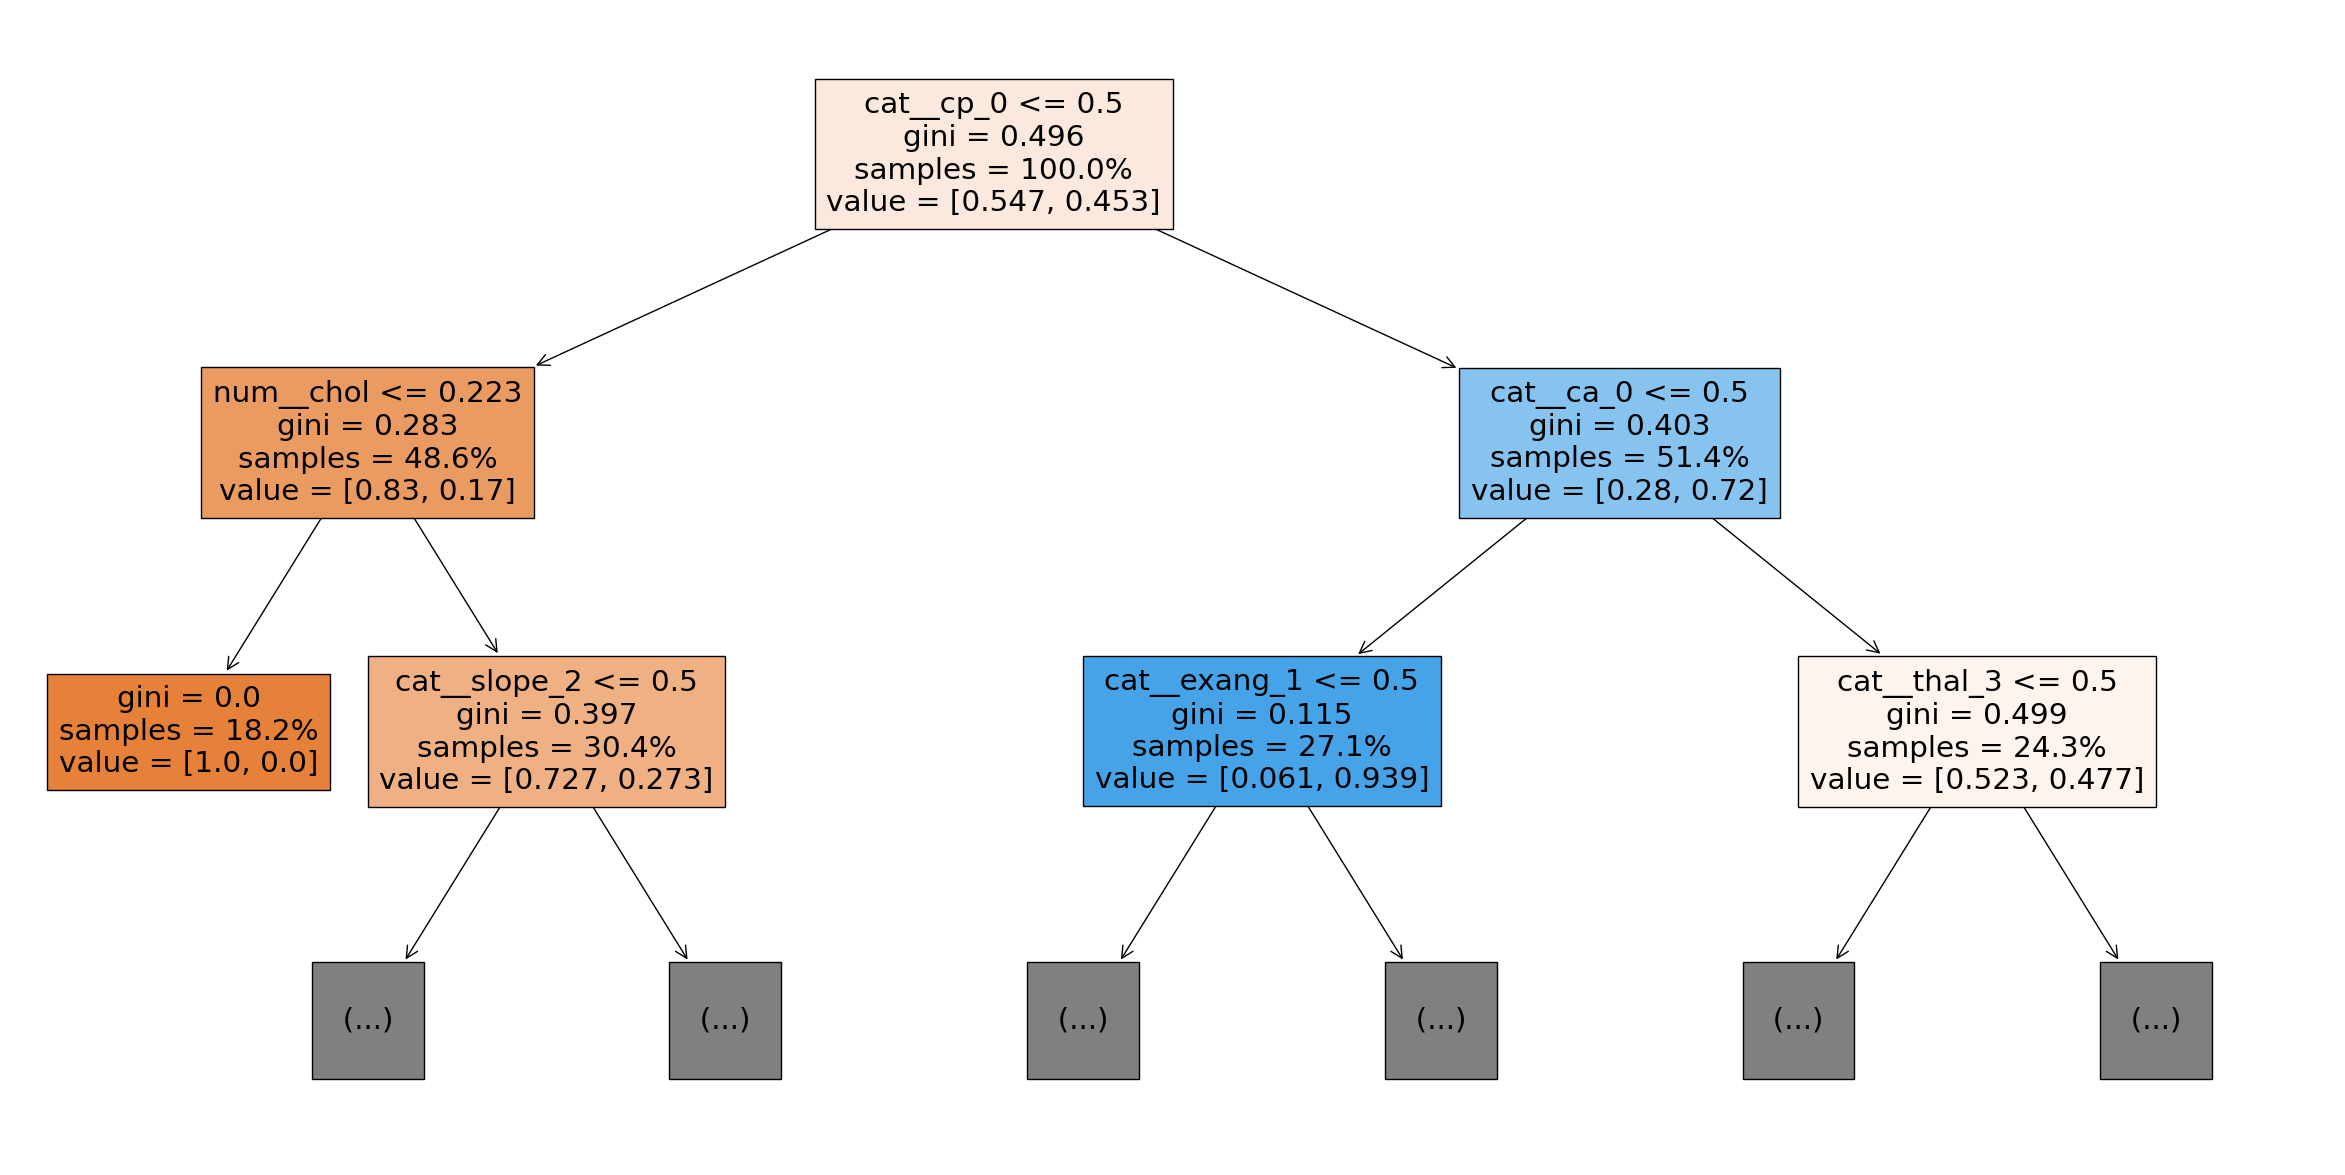

In [37]:
plt.figure(figsize = (30,15)) 
tree.plot_tree(clf,max_depth=2, proportion=True,feature_names=feature_names, filled=True)

**What is the gini index improvement of the first split?**

Response:
Gini Improvement = G(Parent) - (p_1*G(c_1) + p_2*G(c_2))
=> .496 - ((.486*.283) + (.514 * .403))
=> .151

### [5 pts] Plot the importance of each feature for the Decision Tree

cat__cp_0         0.304932
num__chol         0.129301
cat__ca_0         0.116845
num__thalach      0.101678
cat__thal_3       0.086105
cat__slope_2      0.053376
num__oldpeak      0.048016
cat__thal_2       0.030665
cat__cp_2         0.029861
cat__exang_0      0.023225
cat__thal_0       0.017625
num__trestbps     0.017518
cat__slope_0      0.016157
num__age          0.009555
cat__exang_1      0.007709
cat__sex_1        0.007432
cat__restecg_1    0.000000
cat__restecg_0    0.000000
cat__fbs_1        0.000000
cat__fbs_0        0.000000
cat__slope_1      0.000000
cat__cp_3         0.000000
cat__cp_1         0.000000
cat__ca_1         0.000000
cat__ca_2         0.000000
cat__ca_3         0.000000
cat__ca_4         0.000000
cat__thal_1       0.000000
cat__sex_0        0.000000
cat__restecg_2    0.000000
dtype: float64


<AxesSubplot: >

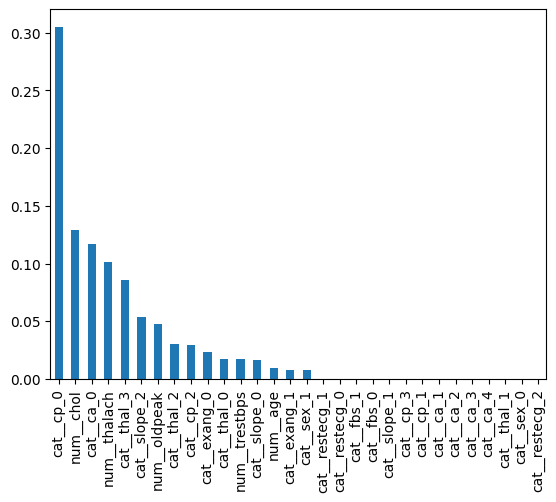

In [38]:
imp_pd = pd.Series(data = clf.feature_importances_ ,index = feature_names)
imp_pd= imp_pd.sort_values(ascending=False)
print(imp_pd)
imp_pd.plot.bar()

**How many features have non-zero importance for the Decision Tree? If we remove the features with zero importance, will it change the decision tree for the same sampled dataset?** 

Response: 
16 features have non-zero importance.  These features are: cat__cp_0, num__chol, cat__ca_0, num__thalach, cat__thal_3, cat__slope_2, num__oldpeak, cat__thal_2, cat__cp_2, cat__exang_0, cat__thal_0, num__trestbps, cat__slope_0, num__age, cat__exang_1, cat__sex_1, cat__restecg_1.  We can drop the features with zero importance without changing the decision tree as none of them are splitting features within the first two levels.

### [10 pts] Optimize Decision Tree

While the default Decision Tree performs fairly well on the data, lets see if we can improve performance by optimizing the parameters.

Run a GridSearchCV with 3-Fold Cross Validation for the Decision Tree. Find the best model parameters amongst the following:

- max_depth = [1,2,3,4,5,10,15]
- min_samples_split = [2,4,6,8]
- criterion = ["gini", "entropy"]

After using GridSearchCV, print the best model parameters and the best score.

In [39]:
parameters = [
    {"max_depth": [1,2,3,4,5,10,15],
    "min_samples_split": [2,4,6,8],
    "criterion": ["gini","entropy"]}
]

k = 3
kf = KFold(n_splits=k, random_state=None)

clf = DecisionTreeClassifier(criterion="gini", random_state = 0)
grid = GridSearchCV(clf, parameters, cv = kf, scoring = "accuracy")
grid.fit(train,target)
#Put results into Dataframe
res= pd.DataFrame(grid.cv_results_)
res

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.002275      0.000255         0.000985        0.000138   
1        0.002237      0.000207         0.001014        0.000098   
2        0.002444      0.000412         0.000934        0.000149   
3        0.002652      0.000309         0.000915        0.000090   
4        0.002501      0.000189         0.001030        0.000253   
5        0.002191      0.000224         0.001292        0.000622   
6        0.001948      0.000107         0.000854        0.000233   
7        0.002408      0.000474         0.000738        0.000302   
8        0.002059      0.000453         0.000713        0.000073   
9        0.001959      0.000214         0.001017        0.000601   
10       0.001931      0.000106         0.000628        0.000091   
11       0.001926      0.000166         0.000713        0.000056   
12       0.001958      0.000156         0.000558        0.000036   
13       0.001967      0.000127         0.000849        0.000234   
14       0.002023      0.000082         0.000596        0.000094   
15       0.002158      0.000050         0.000777        0.000139   
16       0.002004      0.000239         0.000561        0.000066   
17       0.002181      0.000363         0.000715        0.000180   
18       0.001834      0.000064         0.000668        0.000247   
19       0.002076      0.000154         0.000605        0.000077   
20       0.001822      0.000174         0.000567        0.000067   
21       0.001911      0.000113         0.000565        0.000023   
22       0.002113      0.000214         0.000739        0.000293   
23       0.002009      0.000223         0.000576        0.000009   
24       0.001985      0.000117         0.000497        0.000008   
25       0.001863      0.000128         0.000850        0.000287   
26       0.001874      0.000054         0.000548        0.000017   
27       0.001880      0.000202         0.000540        0.000044   
28       0.001575      0.000102         0.000497        0.000018   
29       0.003268      0.002173         0.000689        0.000130   
30       0.001718      0.000084         0.000589        0.000082   
31       0.001719      0.000186         0.000665        0.000117   
32       0.001905      0.000111         0.000659        0.000055   
33       0.001915      0.000256         0.000588        0.000099   
34       0.001795      0.000056         0.000679        0.000185   
35       0.001844      0.000183         0.000594        0.000061   
36       0.002208      0.000320         0.000612        0.000074   
37       0.001907      0.000071         0.000602        0.000063   
38       0.001822      0.000099         0.000516        0.000031   
39       0.001921      0.000151         0.000574        0.000075   
40       0.002367      0.000465         0.000535        0.000063   
41       0.001953      0.000038         0.000620        0.000149   
42       0.002261      0.000320         0.001098        0.000200   
43       0.002305      0.000233         0.000758        0.000116   
44       0.002639      0.000344         0.000791        0.000147   
45       0.002167      0.000131         0.000561        0.000030   
46       0.002224      0.000188         0.000541        0.000009   
47       0.002026      0.000071         0.000660        0.000170   
48       0.002419      0.000546         0.000526        0.000021   
49       0.002924      0.000753         0.000819        0.000116   
50       0.002309      0.000085         0.000678        0.000040   
51       0.002363      0.000146         0.000813        0.000083   
52       0.002322      0.000039         0.000670        0.000046   
53       0.002406      0.000362         0.000706        0.000143   
54       0.002893      0.000132         0.000969        0.000142   
55       0.002396      0.000551         0.000707        0.000138   

   param_criterion param_max_depth param_min_samples_split  \
0             gini               1                       2   
1  

In [40]:
res[["rank_test_score","param_criterion", "param_max_depth", "param_min_samples_split","mean_test_score"]].sort_values(by=['rank_test_score'])

rank_test_score param_criterion param_max_depth param_min_samples_split  \
55                1         entropy              15                       8   
51                1         entropy              10                       8   
43                1         entropy               4                       8   
42                4         entropy               4                       6   
41                4         entropy               4                       4   
40                4         entropy               4                       2   
53                7         entropy              15                       4   
49                7         entropy              10                       4   
46                7         entropy               5                       6   
45                7         entropy               5                       4   
47               11         entropy               5                       8   
31               12         entropy               1                       8   
30               12         entropy               1                       6   
29               12         entropy               1                       4   
28               12         entropy               1                       2   
0                12            gini               1                       2   
1                12            gini               1                       4   
2                12            gini               1                       6   
3                12            gini               1                       8   
39               20         entropy               3                       8   
38               20         entropy               3                       6   
37               20         entropy               3                       4   
36               20         entropy               3                       2   
52               24         entropy              15                       2   
44               24         entropy               5                       2   
50               26         entropy              10                       6   
54               26         entropy              15                       6   
20               28            gini              10                       2   
24               28            gini              15                       2   
16               30            gini               5                       2   
27               31            gini              15                       8   
23               31            gini              10                       8   
11               33            gini               3                       8   
10               33            gini               3                       6   
9                33            gini               3                       4   
8                33            gini               3                       2   
48               37         entropy              10                       2   
17               38            gini               5                       4   
13               39            gini               4                       4   
19               40            gini               5                       8   
15               40            gini               4                       8   
4                42            gini               2                       2   
5                42            gini               2                       4   
6                42            gini               2                       6   
7                42            gini               2                       8   
14               46            gini               4                       6   
18               46            gini               5                       6   
12               46            gini               4                       2   
34               49         entropy               2                       6   
33               49         entropy               2   

**Using the best model you have, report the test accuracy and print out the confusion matrix**

Accuracy:    0.737705


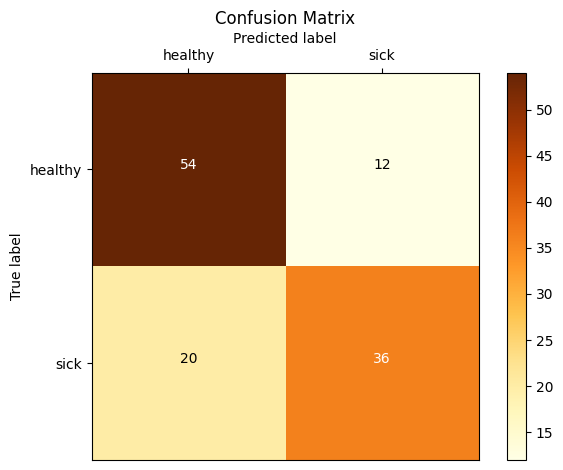

In [41]:
predicted = grid.predict(test)
print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(target_test,predicted)))
draw_confusion_matrix(target_test, predicted, ['healthy', 'sick'])

## (20 pts) Multi-Layer Perceptron

### [5 pts] Applying a Multi-Layer Perceptron
Apply the MLP on the **train data** with hidden_layer_sizes=(100,100) and max_iter = 800. **Report the accuracy and print the confusion matrix**. Make sure to set random_state=0. 

Accuracy:    0.819672
Confusion Matrix: 
 [[63  3]
 [19 37]]


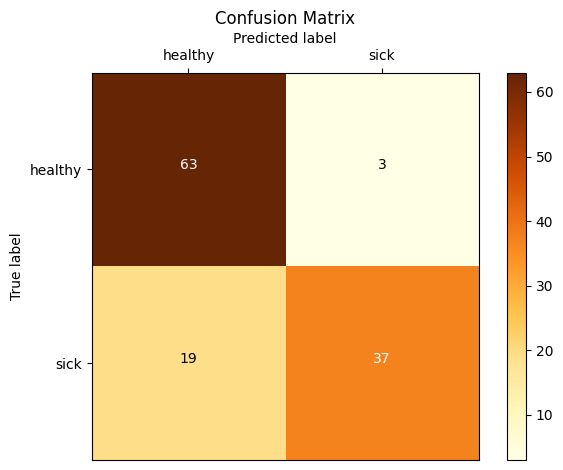

In [42]:
clf = MLPClassifier(hidden_layer_sizes = (100,100), max_iter = 800, random_state = 0)
clf.fit(train, target)
predicted = clf.predict(test)
print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(target_test,predicted)))
print("Confusion Matrix: \n", metrics.confusion_matrix(target_test,predicted))
draw_confusion_matrix(target_test, predicted, ['healthy', 'sick'])

### [10 pts] Speedtest between Decision Tree and MLP

Let us compare the training times and prediction times of a Decision Tree and an MLP. **Time how long it takes for a Decision Tree and an MLP to perform a .fit operation (i.e. training the model). Then, time how long it takes for a Decision Tree and an MLP to perform a .predict operation (i.e. predicting the testing data). Print out the timings and specify which model was quicker for each operation.** We recommend using the [time](https://docs.python.org/3/library/time.html) python module to time your code. 
An example of the time module was shown in project 2. Use the default Decision Tree Classifier and the MLP with the previously mentioned parameters.

In [43]:
clfd = DecisionTreeClassifier(criterion="gini", random_state = 0)
t0 = time.time()
clfd.fit(train, target)
t1 = time.time()
dtcttime = t1-t0
print("Decision Tree Training Time : ", dtcttime)
t0 = time.time()
clfd.predict(test)
t1 = time.time()
dtcptime = t1-t0
print("Decision Tree Predict Time : ", dtcptime)

clfm = MLPClassifier(hidden_layer_sizes = (100,100), max_iter = 800, random_state = 0)
t0 = time.time()
clfm.fit(train, target)
t1 = time.time()
mlpttime = t1-t0
print("MLP Training Time : ", mlpttime)
t0 = time.time()
clfm.predict(test)
t1 = time.time()
mlpptime = t1-t0
print("MLP Predict Time : ", mlpptime)

Decision Tree Training Time :  0.0033843517303466797
Decision Tree Predict Time :  0.0005855560302734375
MLP Training Time :  1.2351632118225098
MLP Predict Time :  0.0008776187896728516


As seen above, the decision tree was faster for both training and prediction.

### [5 pts] Compare and contrast Decision Trees and MLPs.

**Describe at least one advantage and disadvantage of using an MLP over a Decision Tree.**

Response:
MLP models perform better the more complex a data set it.  This is especially true when the decision boundaries for classification/regression tasks cannot be seperated by axis based bounds.  However, when decision boundaries can be set by horizontal and vertical bounds then decision trees often perform better and are easier to use and interpret.

## (35 pts) PCA

### [5 pts] Transform the train data using PCA

Train a PCA model to project the train data on the top 10 components. **Print out the 10 principal components**. Look at the documentation of [PCA](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) for reference.

In [44]:
pca = PCA(n_components = 10)
pca_pipe = Pipeline([("scaler",StandardScaler()), #Scikit learn PCA does not standardize so we need to add
               ("pca",pca)])
pca_pipe.fit(train)

print(pca.singular_values_)

[30.93700171 22.00270214 20.79491454 18.50632992 17.43476832 16.75037207
 16.37675581 16.27252985 15.25552037 14.84463047]


### [5 pts] Percentage of variance explained by top 10 principal components

Using PCA's "explained_variance_ratio_", print the percentage of variance explained by the top 10 principal components.

In [45]:
print(pca.explained_variance_ratio_)

[0.17626116 0.08915634 0.07963692 0.06307261 0.05597995 0.05167126
 0.04939192 0.04876524 0.0428602  0.04058251]


### [5 pts] Transform the train and test data into train_pca and test_pca using PCA

Note: Use fit_transform for train and transform for test

In [46]:
train_pca = pca.transform(train)
test_pca = pca.transform(test)

### [5 pts] PCA+Decision Tree

Train the default Decision Tree Classifier using train_pca. **Report the accuracy using test_pca and print the confusion matrix**.

Accuracy:    0.745902
Confusion Matrix: 
 [[54 12]
 [19 37]]


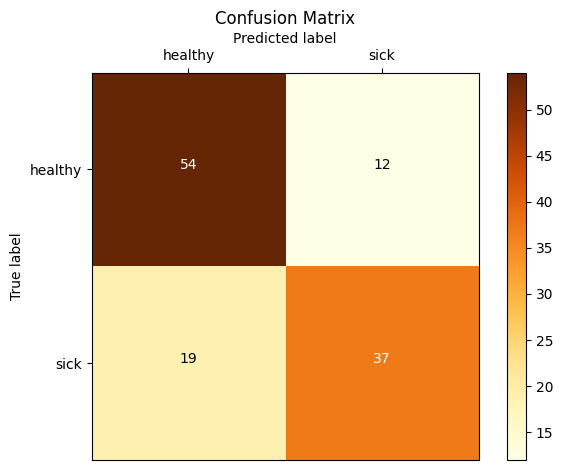

In [47]:
clf = DecisionTreeClassifier(criterion="gini", random_state = 0)
clf.fit(train_pca, target)
predicted = clf.predict(test_pca)
print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(target_test,predicted)))
print("Confusion Matrix: \n", metrics.confusion_matrix(target_test,predicted))
draw_confusion_matrix(target_test, predicted, ['healthy', 'sick'])

**Does the model perform better with or without PCA?**

Response: The model performed better with pca.

### [5 pts] PCA+MLP

Train the MLP classifier with the same parameters as before using train_pca. **Report the accuracy using test_pca and print the confusion matrix**.

Accuracy:    0.778689
Confusion Matrix: 
 [[59  7]
 [20 36]]


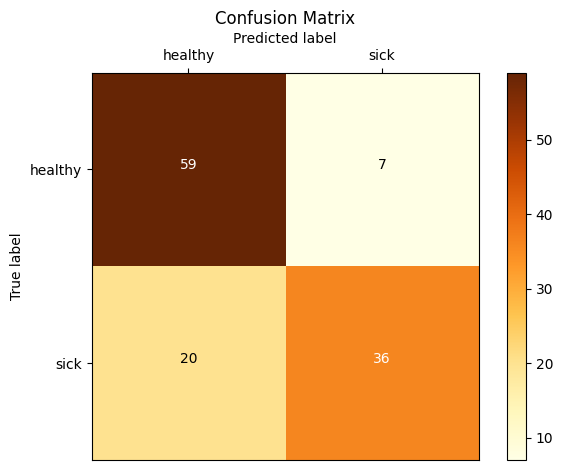

In [48]:
clf = MLPClassifier(hidden_layer_sizes = (100,100), max_iter = 800, random_state = 0)
clf.fit(train_pca, target)
predicted = clf.predict(test_pca)
print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(target_test,predicted)))
print("Confusion Matrix: \n", metrics.confusion_matrix(target_test,predicted))
draw_confusion_matrix(target_test, predicted, ['healthy', 'sick'])

**Does the model perform better with or without PCA?**

Response: The model performs worse with pca.

### [10 pts] Pros and Cons of PCA

**In your own words, provide at least two pros and at least two cons for using PCA**

Response: PCA is beneficial as it reduces the dimensionality of the data which prevents overfitting and helps with visualization.  PCA however cannot be used effectively when the data has uncorrelated features or is not linear.

## (20 pts) K-Means Clustering

### [5 pts] Apply K-means to the train data and print out the Inertia score

Use n_cluster = 5 and random_state = 0.

In [49]:
kmeans = KMeans(n_clusters = 5, random_state = 0)
kmeans.fit(train)
print(f"Inertia for K = 5: {kmeans.inertia_}")

Inertia for K = 5: 491.0665663612592


### [10 pts] Find the optimal cluster size using the elbow method. 

Use the elbow method to find the best cluster size or range of best cluster sizes for the train data. Check the cluster sizes from 2 to 20. Make sure to plot the Inertia and state where you think the elbow starts. Make sure to use random_state = 0.

Inertia for K = 2: 619.2596852490838
Inertia for K = 3: 562.2941749488493
Inertia for K = 4: 515.3501104402982
Inertia for K = 5: 491.0665663612592
Inertia for K = 6: 458.34490628572456
Inertia for K = 7: 436.4673131159211
Inertia for K = 8: 427.64243132453544
Inertia for K = 9: 409.3453854307659
Inertia for K = 10: 393.8362013824141
Inertia for K = 11: 375.627142914177
Inertia for K = 12: 366.8725741918041
Inertia for K = 13: 356.07044286127075
Inertia for K = 14: 353.0506627827144
Inertia for K = 15: 342.9664892654279
Inertia for K = 16: 335.82888467728145
Inertia for K = 17: 325.33654094415056
Inertia for K = 18: 310.3448076066396
Inertia for K = 19: 306.7095752890683


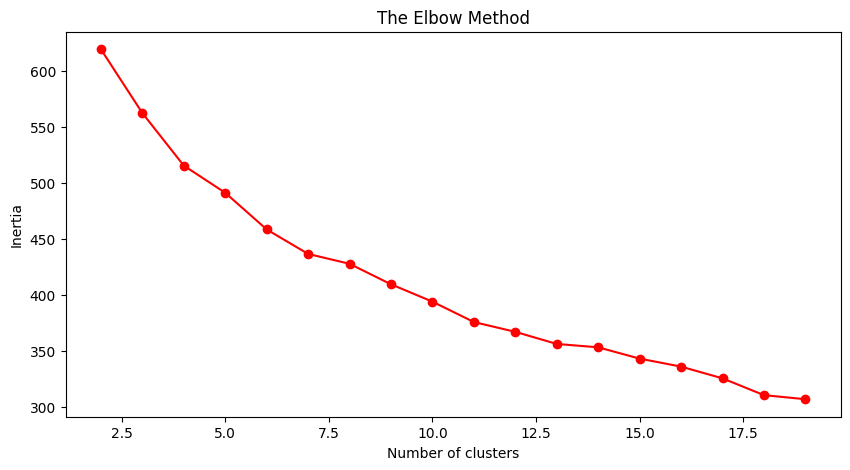

In [50]:
ks = list(range(2,20))
inertia = []
for k in ks:
    kmeans = KMeans(n_clusters = k, init = 'k-means++', random_state = 0)
    kmeans.fit(train)
    # inertia method returns wcss for that model
    inertia.append(kmeans.inertia_)
    print(f"Inertia for K = {k}: {kmeans.inertia_}")
plt.figure(figsize=(10,5))
plt.plot(ks, inertia,marker='o',color='red')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

The elbow appears to be between 5 and 10 clusters

### [5 pts] Find the optimal cluster size for the train_pca data
 
Repeat the same experiment but use train_pca instead of train. 

Inertia for K = 2: 454.6323855838633
Inertia for K = 3: 402.1013219723234
Inertia for K = 4: 366.00606255931257
Inertia for K = 5: 334.64480327877766
Inertia for K = 6: 313.87091527065974
Inertia for K = 7: 296.41743714338634
Inertia for K = 8: 280.1237570630844
Inertia for K = 9: 266.7442004340305
Inertia for K = 10: 257.4176549517501
Inertia for K = 11: 242.91165865721095
Inertia for K = 12: 236.47596329430155
Inertia for K = 13: 222.07641841588259
Inertia for K = 14: 218.01180007302983
Inertia for K = 15: 207.70820145485737
Inertia for K = 16: 195.68790653680145
Inertia for K = 17: 192.5872790431151
Inertia for K = 18: 182.91446968159318
Inertia for K = 19: 179.43395320163512


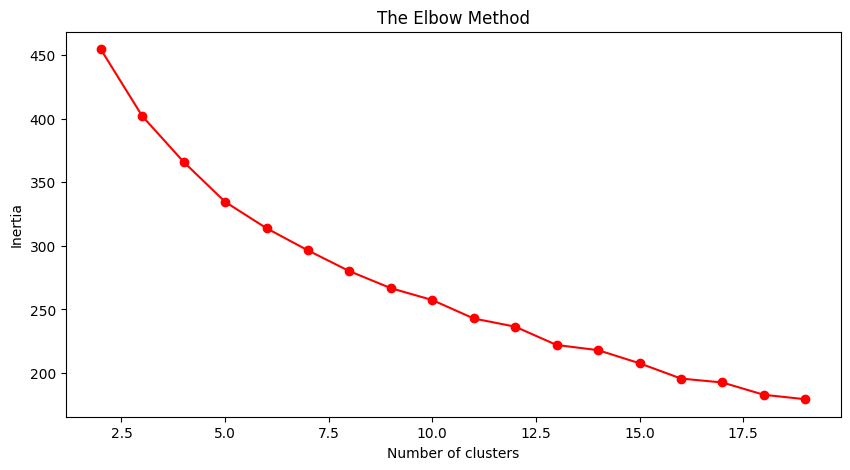

In [51]:
ks = list(range(2,20))
inertia = []
for k in ks:
    kmeans = KMeans(n_clusters = k, init = 'k-means++', random_state = 0)
    kmeans.fit(train_pca)
    # inertia method returns wcss for that model
    inertia.append(kmeans.inertia_)
    print(f"Inertia for K = {k}: {kmeans.inertia_}")
plt.figure(figsize=(10,5))
plt.plot(ks, inertia,marker='o',color='red')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()

**Notice that the inertia is much smaller for every cluster size when using PCA features. Why do you think this is happening? Hint: Think about what Inertia is calculating and consider the number of features that PCA outputs.**

Response: One reason intertia may be smaller is because the data is standardized before being passed through pca. Furthermore, by projecting the data onto its pca components we are reducing the variance in the data to only the variance explained by those 10 principle components.

# (100 pts) Putting it all together

Through all the homeworks and projects, you have learned how to apply many different models to perform a supervised learning task. We are now asking you to take everything that you learned to create a model that can predict whether a hotel reservation will be canceled or not.


**Context**

Hotels see millions of people every year and always wants to keep rooms occupied and payed for. Cancellations make the business lose money since it may make it difficult to reserve to another customer on such short notice. As such, it is useful for a hotel to know whether a reservation is likely to cancel or not. The following dataset will provide a variety of information about a booking that you will use to predict whether that booking will cancel or not. 


Property Management System - PMS

**Attribute Information**

(C) is for Categorical 

(N) is for Numeric

    1) is_canceled (C) : Value indicating if the booking was canceled (1) or not (0).
    2) hotel (C) : The datasets contains the booking information of two hotel. One of the hotels is a resort hotel and the other is a city hotel.
    3) arrival_date_month (C): Month of arrival date with 12 categories: “January” to “December”
    4) stays_in_weekend_nights (N): Number of weekend nights (Saturday or Sunday) the guest stayed or booked to stay at the hotel
    5) stays_in_week_nights (N): Number of week nights (Monday to Friday) the guest stayed or booked to stay at the hotel BO and BL/Calculated by counting the number of week nights
    6) adults (N): Number of adults
    7) children (N): Number of children
    8) babies (N): Number of babies
    9) meal (C): Type of meal
    10) country (C): Country of origin.
    11) previous_cancellations (N): Number of previous bookings that were canceled by the customer prior to the current booking
    12) previous_bookings_not_canceled (N) : Number of previous bookings not canceled by the customer prior to the current booking
    13) reserved_room_type (C): Code of room type reserved. Code is presented instead of designation for anonymity reasons
    14) booking_changes (N) : Number of changes/amendments made to the booking from the moment the booking was entered on the PMS until the moment of check-in or cancellation
    15) deposit_type (C) : No Deposit – no deposit was made; Non Refund – a deposit was made in the value of the total stay cost; Refundable – a deposit was made with a value under the total cost of stay
    16) days_in_waiting_list (N): Number of days the booking was in the waiting list before it was confirmed to the customer
    17) customer_type (C): Group – when the booking is associated to a group; Transient – when the booking is not part of a group or contract, and is not associated to other transient booking; Transient-party – when the booking is transient, but is associated to at least other transient booking
    18) adr (N): Average Daily Rate (Calculated by dividing the sum of all lodging transactions by the total number of staying nights)
    19) required_car_parking_spaces (N): Number of car parking spaces required by the customer
    20) total_of_special_requests (N): Number of special requests made by the customer (e.g. twin bed or high floor)
    21) name (C): Name of the Guest (Not Real)
    22) email (C): Email (Not Real)
    23) phone-number (C): Phone number (not real)

This dataset is quite large with 86989 samples. This makes it difficult to just brute force running a lot of models. As such, you have to be thoughtful when designing your models.

The file name for the training data is "hotel_booking.csv".

**Challenge**

This project is about being able to predict whether a reservation is likely to cancel based on the
input parameters available to us. We will ask you to perform some specific instructions to lead you in the right direction but you are given free reign on which models to use and the preprocessing steps you make. We will ask you to **write out a description of what models you choose and why you choose them**.

## (50 pts) Preprocessing


**Preprocessing:**
For the dataset, the following are mandatory pre-processing steps for your data:

- Use One-Hot Encoding on all categorical features (specify whether you keep the extra feature or not for features with multiple values)
- Determine which fields need to be dropped
- Handle missing values (Specify your strategy)
- Rescale the real valued features using any strategy you choose (StandardScaler, MinMaxScaler, Normalizer, etc)
- Augment at least one feature
- Implement a train-test split with 20% of the data going to the test data. Make sure that the test and train data are balanced in terms of the desired class.


After writing your preprocessing code, write out a description of what you did for each step and provide a justification for your choices. All descriptions should be written in the markdown cells of the jupyter notebook. Make sure your writing is clear and professional.  

We highly recommend reading through the [scikit-learn documentation](https://scikit-learn.org/stable/data_transforms.html) to make this part easier.

Plan:
1)Import Data
2)Correct Missing Values
3)Augment Features
    -Cancelation Rate
4)Drop Fields
5)Pipeline

In [52]:
#Preprocess Data
#1)Import Data
data = pd.read_csv('datasets/hotel_booking.csv')
data.head()

is_canceled         hotel  lead_time arrival_date_month  \
0            0  Resort Hotel          4           February   
1            1    City Hotel        172               June   
2            0    City Hotel          4           November   
3            1    City Hotel         68          September   
4            1    City Hotel        149               July   

   stays_in_weekend_nights  stays_in_week_nights  adults  children  babies  \
0                        1                     2       2       0.0       0   
1                        0                     2       1       0.0       0   
2                        2                     1       1       0.0       0   
3                        0                     2       2       0.0       0   
4                        2                     4       3       0.0       0   

  meal  ... booking_changes  deposit_type  days_in_waiting_list  \
0   FB  ...               0    No Deposit                     0   
1   BB  ...               0    No Deposit                     0   
2   BB  ...               0    No Deposit                     0   
3   HB  ...               0    No Deposit                     0   
4   BB  ...               0    No Deposit                     0   

     customer_type    adr required_car_parking_spaces  \
0        Transient   75.0                           0   
1  Transient-Party   95.0                           0   
2        Transient   65.0                           0   
3  Transient-Party    0.0                           0   
4        Transient  167.7                           0   

   total_of_special_requests             name                         email  \
0                          1      Linda Moore                LMoore@att.com   
1                          0   Madison Greene  Greene_Madison56@verizon.com   
2                          0  Alicia Richards   Richards.Alicia@comcast.net   
3                          0    Gregory Smith      GregorySmith@outlook.com   
4                          0  Rachel Martinez          Rachel.M@outlook.com   

   phone-number  
0  217-602-3707  
1  791-162-2669  
2  442-385-2754  
3  670-687-2703  
4  692-194-2274  

[5 rows x 24 columns]

In [53]:
data["is_canceled"].value_counts()

0    46519
1    31771
Name: is_canceled, dtype: int64

In [54]:
#2)Correct Missing Values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78290 entries, 0 to 78289
Data columns (total 24 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   is_canceled                     78290 non-null  int64  
 1   hotel                           78290 non-null  object 
 2   lead_time                       78290 non-null  int64  
 3   arrival_date_month              78290 non-null  object 
 4   stays_in_weekend_nights         78290 non-null  int64  
 5   stays_in_week_nights            78290 non-null  int64  
 6   adults                          78290 non-null  int64  
 7   children                        78287 non-null  float64
 8   babies                          78290 non-null  int64  
 9   meal                            78290 non-null  object 
 10  country                         78290 non-null  object 
 11  previous_cancellations          78290 non-null  int64  
 12  previous_bookings_not_canceled  

After placing the data into a pandas df, I used the info function to see if there were any missing values in the data.  There were a few null values in the 'children' column so I assumed no children and replaced those nan values with 0.

In [55]:
data["children"].fillna(0.0, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78290 entries, 0 to 78289
Data columns (total 24 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   is_canceled                     78290 non-null  int64  
 1   hotel                           78290 non-null  object 
 2   lead_time                       78290 non-null  int64  
 3   arrival_date_month              78290 non-null  object 
 4   stays_in_weekend_nights         78290 non-null  int64  
 5   stays_in_week_nights            78290 non-null  int64  
 6   adults                          78290 non-null  int64  
 7   children                        78290 non-null  float64
 8   babies                          78290 non-null  int64  
 9   meal                            78290 non-null  object 
 10  country                         78290 non-null  object 
 11  previous_cancellations          78290 non-null  int64  
 12  previous_bookings_not_canceled  

In [56]:
#3)Augment Features
data["cancel_rate"] = data["previous_cancellations"] / (data["previous_cancellations"] + data["previous_bookings_not_canceled"])
data["cancel_rate"].fillna(data["cancel_rate"].mean(), inplace=True)
pd.set_option('display.max_columns', None)
data.head()

is_canceled         hotel  lead_time arrival_date_month  \
0            0  Resort Hotel          4           February   
1            1    City Hotel        172               June   
2            0    City Hotel          4           November   
3            1    City Hotel         68          September   
4            1    City Hotel        149               July   

   stays_in_weekend_nights  stays_in_week_nights  adults  children  babies  \
0                        1                     2       2       0.0       0   
1                        0                     2       1       0.0       0   
2                        2                     1       1       0.0       0   
3                        0                     2       2       0.0       0   
4                        2                     4       3       0.0       0   

  meal country  previous_cancellations  previous_bookings_not_canceled  \
0   FB     ESP                       0                               0   
1   BB     PRT                       0                               0   
2   BB     PRT                       0                               0   
3   HB     PRT                       0                               0   
4   BB     DEU                       0                               0   

  reserved_room_type  booking_changes deposit_type  days_in_waiting_list  \
0                  A                0   No Deposit                     0   
1                  A                0   No Deposit                     0   
2                  A                0   No Deposit                     0   
3                  A                0   No Deposit                     0   
4                  D                0   No Deposit                     0   

     customer_type    adr  required_car_parking_spaces  \
0        Transient   75.0                            0   
1  Transient-Party   95.0                            0   
2        Transient   65.0                            0   
3  Transient-Party    0.0                            0   
4        Transient  167.7                            0   

   total_of_special_requests             name                         email  \
0                          1      Linda Moore                LMoore@att.com   
1                          0   Madison Greene  Greene_Madison56@verizon.com   
2                          0  Alicia Richards   Richards.Alicia@comcast.net   
3                          0    Gregory Smith      GregorySmith@outlook.com   
4                          0  Rachel Martinez          Rachel.M@outlook.com   

   phone-number  cancel_rate  
0  217-602-3707       0.6613  
1  791-162-2669       0.6613  
2  442-385-2754       0.6613  
3  670-687-2703       0.6613  
4  692-194-2274       0.6613

The augmentation that came to mind was the cancelation rate.  This would be the proportion of bookings that customer has canceled in the past (canceled_bookings / total_bookings).  I felt that if the customer had a history if canceling their bookings then it would be a good indicator as to whether or not this particular booking would get canceled.  By using a percentage instead of a single number we could get a better indication as to whether or not a customer consistently cancels bookings or if it was a one time thing.  For customers without a history of cancelations we set their cancelation rate as the mean of those with a history as that would be the expected chance they would cancel their booking.

In [57]:
#4)Drop Columns
data = data.drop(["name", "email", "phone-number"],axis= 1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78290 entries, 0 to 78289
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   is_canceled                     78290 non-null  int64  
 1   hotel                           78290 non-null  object 
 2   lead_time                       78290 non-null  int64  
 3   arrival_date_month              78290 non-null  object 
 4   stays_in_weekend_nights         78290 non-null  int64  
 5   stays_in_week_nights            78290 non-null  int64  
 6   adults                          78290 non-null  int64  
 7   children                        78290 non-null  float64
 8   babies                          78290 non-null  int64  
 9   meal                            78290 non-null  object 
 10  country                         78290 non-null  object 
 11  previous_cancellations          78290 non-null  int64  
 12  previous_bookings_not_canceled  

Dropped name, email, and phone number columns as they hold no real value.  Features like required car spaces, meal, country of origin, etc may not appear directly related to chances of canceling a booking but I justified keeping them under the assumption that they may indicate income or other external attributes that may influence that persons attitudes towards canceling bookings.

In [58]:
corr_matrix = data.corr()
corr_matrix["is_canceled"].sort_values(ascending=False)

/tmp/ipykernel_17811/1951794863.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_matrix = data.corr()


is_canceled                       1.000000
lead_time                         0.326806
cancel_rate                       0.293942
previous_cancellations            0.119770
days_in_waiting_list              0.070779
adults                            0.057706
adr                               0.035421
stays_in_week_nights              0.019298
stays_in_weekend_nights          -0.012650
children                         -0.018884
babies                           -0.035107
previous_bookings_not_canceled   -0.067611
booking_changes                  -0.167787
required_car_parking_spaces      -0.216903
total_of_special_requests        -0.248947
Name: is_canceled, dtype: float64

As we can see cancel rate is highly correlated with the cancelation status of our current booking.

In [59]:
#5)Pipeline
"""
#Transform target feature into numerical
le = LabelEncoder() 
data['hotel'] = le.fit_transform(data['hotel'])
data['arrival_date_month'] = le.fit_transform(data['arrival_date_month'])
data['meal'] = le.fit_transform(data['meal'])
data['country'] = le.fit_transform(data['country'])
data['reserved_room_type'] = le.fit_transform(data['reserved_room_type'])
data['deposit_type'] = le.fit_transform(data['deposit_type'])
data['customer_type'] = le.fit_transform(data['customer_type'])
"""

#Split target and data
y = data["is_canceled"]
x = data.drop(["is_canceled"],axis = 1)

#Train test split
train_raw, test_raw, target, target_test = train_test_split(x,y, test_size=0.2, stratify= y, random_state=0)

#Splits names into numerical and categorical features
numerical_features = ["stays_in_weekend_nights", "stays_in_week_nights", "adults", "children", "babies"
                      "previous_cancellations", "previous_bookings_not_canceled", "booking_changes",
                      "days_in_waiting_list", "adr", "required_car_parking_spaces", "total_of_special_requests",
                      "cancel_rate"]
categorical_features = ["hotel", "arrival_date_month", "meal", "country", "reserved_room_type", "deposit_type", 
                        "customer_type"]

num_pipeline = Pipeline([('std_scaler', StandardScaler())])

#Applies different transformations on numerical columns vs categorial columns
full_pipeline = ColumnTransformer([
        ("num", num_pipeline, numerical_features),
        ("cat", OneHotEncoder(categories='auto'), categorical_features),
    ])

#Transform raw data 
train = pipeline.fit_transform(train_raw)
test = pipeline.transform(test_raw)

#Names of Features after Pipeline
feature_names = list(pipeline.get_feature_names_out(list(x.columns)))

We used a stratified 80-20 split on our data in accordance with the spec.  We scaled our numeric values with the standard scalar and one hot encoded our categorical data.

In [60]:
train.shape

(62632, 21)

In [61]:
test.shape

(15658, 21)

## (50 pts) Try out a few models
Now that you have pre-processed your data, you are ready to try out different models. 

For this part of the project, we want you to experiment with all the different models demonstrated in the course to determine which one performs best on the dataset.

You must perform classification using at least 3 of the following models:
- Logistic Regression
- K-nearest neighbors
- SVM
- Decision Tree
- Multi-Layer Perceptron

Due to the size of the dataset, be careful which models you use and look at their documentation to see how you should tackle this size issue for each model.

For full credit, you must perform some hyperparameter optimization on your models of choice. You may find the following scikit-learn library on [hyperparameter optimization](https://scikit-learn.org/stable/modules/grid_search.html#grid-search) useful.

For each model chosen, write a description of which models were chosen, which parameters you optimized, and which parameters you choose for your best model. 
While the previous part of the project asked you to pre-process the data in a specific manner, you may alter pre-processing step as you wish to adjust for your chosen classification models.


# Decision Tree

In [62]:
parameters = [
    {"max_depth": [1,2,3,4,5,10,15],
    "min_samples_split": [2,4,6,8],
    "criterion": ["gini","entropy"]}
]

k = 10
kf = KFold(n_splits=k, random_state=None)

clf = DecisionTreeClassifier(criterion="gini", random_state = 0)
grid = GridSearchCV(clf, parameters, cv = kf, scoring = "accuracy")
grid.fit(train,target)
#Put results into Dataframe
res= pd.DataFrame(grid.cv_results_)
res

mean_fit_time  std_fit_time  mean_score_time  std_score_time  \
0        0.050227      0.016618         0.001747        0.000305   
1        0.044542      0.003412         0.001889        0.000402   
2        0.043774      0.002608         0.001593        0.000090   
3        0.044189      0.002465         0.001879        0.000340   
4        0.074037      0.004069         0.001668        0.000056   
5        0.071100      0.003426         0.001776        0.000140   
6        0.071604      0.003255         0.001787        0.000346   
7        0.074104      0.004742         0.001896        0.000300   
8        0.101007      0.003942         0.001814        0.000175   
9        0.095320      0.004435         0.001840        0.000264   
10       0.096270      0.003861         0.001824        0.000273   
11       0.094298      0.002201         0.001734        0.000094   
12       0.140784      0.048964         0.002735        0.002064   
13       0.145301      0.031200         0.001970        0.000273   
14       0.137747      0.038262         0.002293        0.000840   
15       0.186608      0.076066         0.002823        0.001980   
16       0.185754      0.070573         0.002077        0.000339   
17       0.145912      0.004967         0.001895        0.000137   
18       0.145175      0.007201         0.001895        0.000148   
19       0.143816      0.008889         0.001800        0.000067   
20       0.228991      0.016608         0.002171        0.000260   
21       0.210948      0.004191         0.002188        0.000372   
22       0.211115      0.004782         0.002001        0.000056   
23       0.211969      0.006747         0.002069        0.000086   
24       0.281530      0.016824         0.002463        0.000220   
25       0.269408      0.008250         0.002271        0.000089   
26       0.270908      0.008866         0.002333        0.000162   
27       0.293416      0.035403         0.002405        0.000204   
28       0.044423      0.002517         0.001686        0.000130   
29       0.044123      0.001301         0.001630        0.000060   
30       0.043483      0.001606         0.001593        0.000053   
31       0.043486      0.002114         0.001699        0.000141   
32       0.085191      0.020788         0.001914        0.000395   
33       0.070829      0.001564         0.001741        0.000165   
34       0.070803      0.001577         0.001743        0.000142   
35       0.071290      0.001636         0.001687        0.000085   
36       0.097899      0.002674         0.001801        0.000209   
37       0.098516      0.004976         0.001780        0.000207   
38       0.097363      0.001446         0.001664        0.000093   
39       0.097589      0.002830         0.001757        0.000141   
40       0.123662      0.005922         0.001845        0.000225   
41       0.121851      0.002290         0.001744        0.000124   
42       0.124187      0.004846         0.001770        0.000104   
43       0.121648      0.003679         0.001772        0.000116   
44       0.141962      0.002513         0.001986        0.000295   
45       0.140973      0.002242         0.001873        0.000152   
46       0.142362      0.004132         0.001848        0.000117   
47       0.141105      0.003249         0.001927        0.000216   
48       0.218111      0.003077         0.002048        0.000138   
49       0.231148      0.018793         0.002097        0.000195   
50       0.219643      0.003362         0.002039        0.000185   
51       0.219523      0.004350         0.001981        0.000156   
52       0.292055      0.003427         0.002241        0.000069   
53       0.293585      0.005654         0.002307        0.000202   
54       0.292384      0.006062         0.002192        0.000058   
55       0.290568      0.003812         0.002301        0.000130   

   param_criterion param_max_depth param_min_samples_split  \
0             gini               1                       2   
1  

In [63]:
res[["rank_test_score","param_criterion", "param_max_depth", "param_min_samples_split",
     "mean_test_score"]].sort_values(by=['rank_test_score'])

rank_test_score param_criterion param_max_depth param_min_samples_split  \
27                1            gini              15                       8   
26                2            gini              15                       6   
25                3            gini              15                       4   
24                4            gini              15                       2   
53                5         entropy              15                       4   
54                6         entropy              15                       6   
55                7         entropy              15                       8   
52                8         entropy              15                       2   
20                9            gini              10                       2   
22               10            gini              10                       6   
21               10            gini              10                       4   
23               12            gini              10                       8   
51               13         entropy              10                       8   
50               14         entropy              10                       6   
48               14         entropy              10                       2   
49               16         entropy              10                       4   
16               17            gini               5                       2   
17               17            gini               5                       4   
18               19            gini               5                       6   
19               19            gini               5                       8   
47               21         entropy               5                       8   
44               21         entropy               5                       2   
45               21         entropy               5                       4   
46               21         entropy               5                       6   
14               25            gini               4                       6   
15               25            gini               4                       8   
12               25            gini               4                       2   
13               25            gini               4                       4   
11               29            gini               3                       8   
9                29            gini               3                       4   
8                29            gini               3                       2   
10               29            gini               3                       6   
38               33         entropy               3                       6   
36               33         entropy               3                       2   
37               33         entropy               3                       4   
39               33         entropy               3                       8   
43               37         entropy               4                       8   
42               37         entropy               4                       6   
41               37         entropy               4                       4   
40               37         entropy               4                       2   
6                41            gini               2                       6   
4                41            gini               2                       2   
5                41            gini               2                       4   
7                41            gini               2                       8   
34               45         entropy               2                       6   
33               45         entropy               2                       4   
32               45         entropy               2                       2   
35               45         entropy               2                       8   
1                49            gini               1                       4   
31               49         entropy               1   

Accuracy:    0.846021


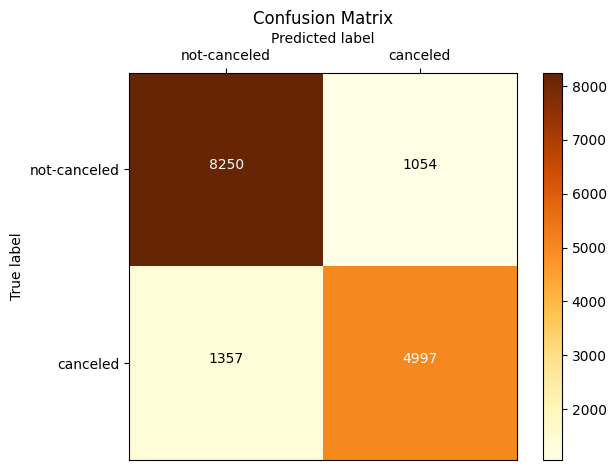

In [64]:
predicted = grid.predict(test)
print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(target_test,predicted)))
draw_confusion_matrix(target_test, predicted, ['not-canceled', 'canceled'])

[Text(0.5, 0.8333333333333334, 'deposit_type <= 0.881\nentropy = 0.974\nsamples = 100.0%\nvalue = [0.594, 0.406]'),
 Text(0.25, 0.5, 'cancel_rate <= 1.207\nentropy = 0.868\nsamples = 83.4%\nvalue = [0.71, 0.29]'),
 Text(0.125, 0.16666666666666666, '\n  (...)  \n'),
 Text(0.375, 0.16666666666666666, '\n  (...)  \n'),
 Text(0.75, 0.5, 'deposit_type <= 3.531\nentropy = 0.094\nsamples = 16.6%\nvalue = [0.012, 0.988]'),
 Text(0.625, 0.16666666666666666, '\n  (...)  \n'),
 Text(0.875, 0.16666666666666666, '\n  (...)  \n')]

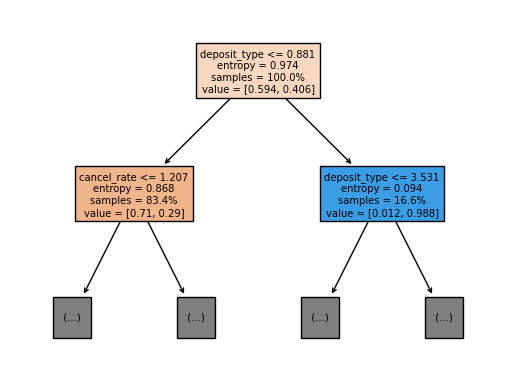

In [65]:
clf = DecisionTreeClassifier(criterion = "entropy", max_depth = 15, min_samples_split = 2, random_state = 0)
clf.fit(train, target)
tree.plot_tree(clf,max_depth=1, proportion=True,feature_names=feature_names, filled=True)

# Logistic Regression

In [66]:
from sklearn.linear_model import LogisticRegression
parameters = [
    {"penalty": ["l2"],
    "C": [0.0001, 0.001, 0.01, 0.1, 1],
    "solver": ["lbfgs", "sag", "saga"]},
    {"penalty": ["l1"],
    "C": [0.0001, 0.001, 0.01, 0.1, 1],
    "solver": ["saga"]},
]

k = 3
kf = KFold(n_splits=k, random_state=None)

clf = LogisticRegression(penalty = "none",max_iter = 1000, solver = "lbfgs")
grid = GridSearchCV(clf, parameters, cv = kf, scoring = "accuracy")
grid.fit(train,target)
#Put results into Dataframe
res= pd.DataFrame(grid.cv_results_)
res

/home/josh/.local/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C  \
0        0.083977      0.021646         0.003094        0.000648  0.0001   
1        0.303062      0.009218         0.004302        0.002251  0.0001   
2        0.305026      0.023063         0.002701        0.000160  0.0001   
3        0.077314      0.001287         0.002490        0.000080   0.001   
4        0.333437      0.006962         0.002742        0.000092   0.001   
5        0.496949      0.049560         0.002776        0.000193   0.001   
6        0.160732      0.008468         0.003835        0.000421    0.01   
7        0.834013      0.269293         0.002864        0.000185    0.01   
8        1.712002      0.435136         0.003111        0.000525    0.01   
9        0.201809      0.011611         0.003878        0.000979     0.1   
10       3.772906      0.401124         0.002744        0.000143     0.1   
11       6.982751      0.732734         0.002741        0.000200     0.1   
12       0.204761      0.018118         0.002903        0.000372       1   
13      12.172907      1.500489         0.002845        0.000119       1   
14      20.346977      2.486854         0.006387        0.002792       1   
15       0.569213      0.234505         0.002914        0.000636  0.0001   
16       0.650921      0.095353         0.004382        0.002000   0.001   
17       2.720442      0.754353         0.003231        0.000729    0.01   
18      14.771483      3.453233         0.003954        0.001846     0.1   
19      38.919612     13.823749         0.004210        0.001885       1   

   param_penalty param_solver  \
0             l2        lbfgs   
1             l2          sag   
2             l2         saga   
3             l2        lbfgs   
4             l2          sag   
5             l2         saga   
6             l2        lbfgs   
7             l2          sag   
8             l2         saga   
9             l2        lbfgs   
10            l2          sag   
11            l2         saga   
12            l2        lbfgs   
13            l2          sag   
14            l2         saga   
15            l1         saga   
16            l1         saga   
17            l1         saga   
18            l1         saga   
19            l1         saga   

                                               params  split0_test_score  \
0   {'C': 0.0001, 'penalty': 'l2', 'solver': 'lbfgs'}           0.789348   
1     {'C': 0.0001, 'penalty': 'l2', 'solver': 'sag'}           0.789252   
2    {'C': 0.0001, 'penalty': 'l2', 'solver': 'saga'}           0.789348   
3    {'C': 0.001, 'penalty': 'l2', 'solver': 'lbfgs'}           0.798161   
4      {'C': 0.001, 'penalty': 'l2', 'solver': 'sag'}           0.798161   
5     {'C': 0.001, 'penalty': 'l2', 'solver': 'saga'}           0.798161   
6     {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}           0.796868   
7       {'C': 0.01, 'penalty': 'l2', 'solver': 'sag'}           0.796868   
8      {'C': 0.01, 'penalty': 'l2', 'solver': 'saga'}           0.796868   
9      {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}           0.796053   
10       {'C': 0.1, 'penalty': 'l2', 'solver': 'sag'}           0.796053   
11      {'C': 0.1, 'penalty': 'l2', 'solver': 'saga'}           0.796053   
12       {'C': 1, 'penalty': 'l2', 'solver': 'lbfgs'}           0.795670   
13         {'C': 1, 'penalty': 'l2', 'solver': 'sag'}           0.795718   
14        {'C': 1, 'penalty': 'l2', 'solver': 'saga'}           0.795718   
15   {'C': 0.0001, 'penalty': 'l1', 'solver': 'saga'}           0.598908   
16    {'C': 0.001, 'penalty': 'l1', 'solver': 'saga'}           0.790066   
17     {'C': 0.01, 'penalty': 'l1', 'solver': 'saga'}           0.796820   
18      {'C': 0.1, 'penalty': 'l1', 'solver': 'saga'}           0.795910   
19        {'C': 1, 'penalty': 'l1', 'solver': 'saga'}           0.795574   

    split1_test_score  split2_test_score  mean_test_score  std_test_score  \
0            0.784883           0.78272

In [67]:
res[["rank_test_score", "param_C", "param_solver", "param_penalty", 
     "mean_test_score"]].sort_values(by=['rank_test_score'])

rank_test_score param_C param_solver param_penalty  mean_test_score
4                 1   0.001          sag            l2         0.793524
3                 2   0.001        lbfgs            l2         0.793508
5                 2   0.001         saga            l2         0.793508
17                4    0.01         saga            l1         0.792454
6                 5    0.01        lbfgs            l2         0.792422
7                 5    0.01          sag            l2         0.792422
8                 5    0.01         saga            l2         0.792422
14                8       1         saga            l2         0.792055
13                8       1          sag            l2         0.792055
19               10       1         saga            l1         0.792039
12               11       1        lbfgs            l2         0.792039
9                12     0.1        lbfgs            l2         0.792039
10               13     0.1          sag            l2         0.792023
11               13     0.1         saga            l2         0.792023
18               15     0.1         saga            l1         0.791991
2                16  0.0001         saga            l2         0.785653
0                16  0.0001        lbfgs            l2         0.785653
1                18  0.0001          sag            l2         0.785637
16               19   0.001         saga            l1         0.785637
15               20  0.0001         saga            l1         0.594185

Accuracy:    0.796270


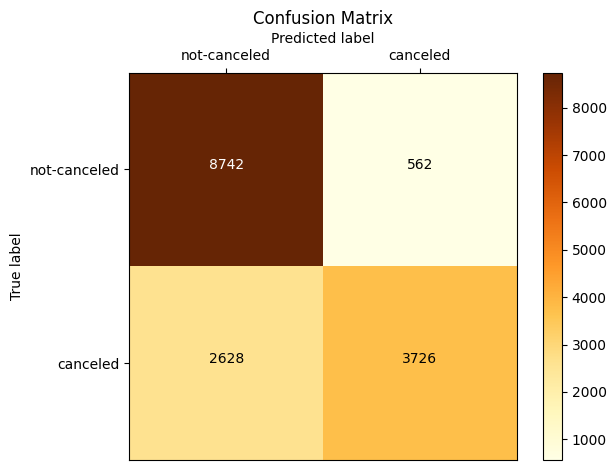

In [68]:
predicted = grid.predict(test)
print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(target_test,predicted)))
draw_confusion_matrix(target_test, predicted, ['not-canceled', 'canceled'])

# MLP

In [69]:
parameters = [
    {"hidden_layer_sizes": [(10,), (10,10), (100,), (100,100)],
    "alpha": [0.00001, 0.0001, 0.001]},
]

k = 3
kf = KFold(n_splits=k, random_state=None)

clf = MLPClassifier(hidden_layer_sizes = (100,), max_iter = 200, random_state = 0)
grid = GridSearchCV(clf, parameters, cv = kf, scoring = "accuracy")
grid.fit(train,target)
#Put results into Dataframe
res= pd.DataFrame(grid.cv_results_)
res

/home/josh/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/josh/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/josh/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/josh/.local/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:702: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/josh/.local/lib/python3.10/site-packages/sklearn/n

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_alpha  \
0       16.913344      5.564310         0.008191        0.002488     0.00001   
1       27.589745      5.463018         0.007555        0.000175     0.00001   
2       54.040271      2.331868         0.017389        0.001083     0.00001   
3      102.295348      0.318944         0.038646        0.006081     0.00001   
4       15.675079      4.940015         0.006630        0.001087      0.0001   
5       24.706074      3.136641         0.007543        0.000225      0.0001   
6       52.891911      1.386127         0.017554        0.003064      0.0001   
7      102.901564      2.221680         0.036476        0.003462      0.0001   
8       15.301954      5.283441         0.007755        0.001944       0.001   
9       25.841370      3.898216         0.007438        0.000212       0.001   
10      54.624301      7.596278         0.015843        0.001630       0.001   
11     100.611088      1.365369         0.052851        0.015632       0.001   

   param_hidden_layer_sizes  \
0                     (10,)   
1                  (10, 10)   
2                    (100,)   
3                (100, 100)   
4                     (10,)   
5                  (10, 10)   
6                    (100,)   
7                (100, 100)   
8                     (10,)   
9                  (10, 10)   
10                   (100,)   
11               (100, 100)   

                                               params  split0_test_score  \
0       {'alpha': 1e-05, 'hidden_layer_sizes': (10,)}           0.840741   
1    {'alpha': 1e-05, 'hidden_layer_sizes': (10, 10)}           0.844813   
2      {'alpha': 1e-05, 'hidden_layer_sizes': (100,)}           0.851854   
3   {'alpha': 1e-05, 'hidden_layer_sizes': (100, 1...           0.843759   
4      {'alpha': 0.0001, 'hidden_layer_sizes': (10,)}           0.839975   
5   {'alpha': 0.0001, 'hidden_layer_sizes': (10, 10)}           0.845962   
6     {'alpha': 0.0001, 'hidden_layer_sizes': (100,)}           0.851135   
7   {'alpha': 0.0001, 'hidden_layer_sizes': (100, ...           0.840646   
8       {'alpha': 0.001, 'hidden_layer_sizes': (10,)}           0.836910   
9    {'alpha': 0.001, 'hidden_layer_sizes': (10, 10)}           0.845196   
10     {'alpha': 0.001, 'hidden_layer_sizes': (100,)}           0.852141   
11  {'alpha': 0.001, 'hidden_layer_sizes': (100, 1...           0.842226   

    split1_test_score  split2_test_score  mean_test_score  std_test_score  \
0            0.835609           0.830627         0.835659        0.004129   
1            0.839201           0.839393         0.841135        0.002601   
2            0.850026           0.844757         0.848879        0.003008   
3            0.849883           0.844374         0.846005        0.002753   
4            0.837572           0.829190         0.835579        0.004623   
5            0.842602           0.839297         0.842620        0.002721   
6            0.849164           0.845284         0.848528        0.002431   
7            0.845859           0.844949         0.843818        0.002274   
8            0.836519           0.830675         0.834701        0.002851   
9            0.842650           0.839967         0.842604        0.002135   
10           0.850889           0.843847         0.848959        0.003650   
11           0.849212           0.841788         0.844409        0.003401   

    rank_test_score  
0                10  
1                 9  
2                 2  
3                 4  
4                11  
5                 7  
6                 3  
7                 6  
8                12  
9                 8  
10                1  
11                5

In [70]:
res[["rank_test_score", "param_hidden_layer_sizes", "param_alpha", 
     "mean_test_score"]].sort_values(by=['rank_test_score'])

rank_test_score param_hidden_layer_sizes param_alpha  mean_test_score
10                1                   (100,)       0.001         0.848959
2                 2                   (100,)     0.00001         0.848879
6                 3                   (100,)      0.0001         0.848528
3                 4               (100, 100)     0.00001         0.846005
11                5               (100, 100)       0.001         0.844409
7                 6               (100, 100)      0.0001         0.843818
5                 7                 (10, 10)      0.0001         0.842620
9                 8                 (10, 10)       0.001         0.842604
1                 9                 (10, 10)     0.00001         0.841135
0                10                    (10,)     0.00001         0.835659
4                11                    (10,)      0.0001         0.835579
8                12                    (10,)       0.001         0.834701

Accuracy:    0.848193


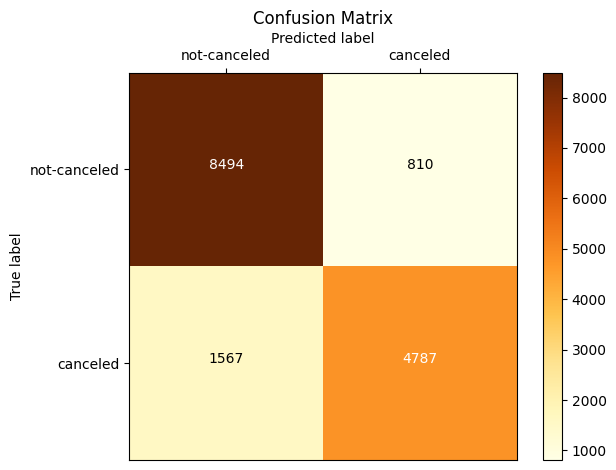

In [71]:
predicted = grid.predict(test)
print("%-12s %f" % ('Accuracy:', metrics.accuracy_score(target_test,predicted)))
draw_confusion_matrix(target_test, predicted, ['not-canceled', 'canceled'])

# Model and Parameter Choices
Decision Tree:
On top of being quick to train, I felt that decision trees would work well since there are a few features where we could very easily split on values.  In particular there was the cancel rate column I created as well as the deposit type.  It seemed very likely that people who have a history of canceling (ie more than the average value) would be more likely to cancel the current booking.  Also, whether or not a booking fee was refundable would play a part in deciding to cancel the booking or not.  The model performed above what was expected with an accuracy of ~84.6%.

Logistic Regression:
I felt that logistic regression worked well here since it was a classification task and it appeared linearly seperable.  For solvers I chose lbfgs as it is the default and sag/saga since they work quickly on large data sets.  I decided to test lower Cs for stronger regularization as we knew some features did not correlate much with the chance of a booking being canceled.  All models used l2 reg except saga which was capable of both l2 and l1 regularization so I decided to also test its l1 regularization capabilities.  Although still exceeding the baseline accuracy at ~79% accuracy, it did not perform as well as 

MLP:
Although slow to train I hoped the added complexity of MLP would allow it to outperform the logistic regression model. I altered the hidden layer sizes parameters to capture some extra complexity in the data.  I also altered alpha since alpha was the most influential hyperparameter in the logistic regression model.  I did not alter the other parameters due to time contraints.  The MLP model beformed the best of all models I tested, just barely surpassing the decision tree classifier with an accuracy of ~84.8%

KNN & SVM:
Both of these models would be infeasible to train/predict with the amount of data we have so I did not choose them.

## Extra Credit 

We have provided an extra test dataset named "hotel_booking_test.csv" that does not have the target labels. Classify the samples in the dataset with your best model and write them into a csv file. Submit your csv file to our [Kaggle](https://www.kaggle.com/t/ed725123bf124e9199c1d8fdc8a2d9c7) contest. The website will specify your classification accuracy on the test set. We will award a bonus point for the project for every percentage point over 75% that you get on your kaggle test accuracy.

To get the bonus points, you must also write out a summary of the model that you submit including any changes you made to the pre-processing steps. The summary must be written in a markdown cell of the jupyter notebook. Note that you should not change earlier parts of the project to complete the extra credit. 

**Kaggle Submission Instruction**
Submit a two column csv where the first column is named "ID" and is the row number. The second column is named "target" and is the classification for each sample. Make sure that the sample order is preserved.

In [78]:
#import
data = pd.read_csv('datasets/hotel_booking_test.csv')
data.head()

hotel  lead_time arrival_date_month  stays_in_weekend_nights  \
0    City Hotel        177             August                        0   
1  Resort Hotel        217             August                        2   
2    City Hotel         65          September                        2   
3    City Hotel        377            October                        0   
4    City Hotel         75                May                        2   

   stays_in_week_nights  adults  children  babies meal country  \
0                     2       2       0.0       0   SC     FRA   
1                     5       2       1.0       0   HB     PRT   
2                     1       2       0.0       0   HB     PRT   
3                     2       2       0.0       0   HB     DEU   
4                     1       2       0.0       0   BB     PRT   

   previous_cancellations  previous_bookings_not_canceled reserved_room_type  \
0                       0                               0                  A   
1                       0                               0                  A   
2                       0                               0                  A   
3                       0                               0                  A   
4                       0                               0                  A   

   booking_changes deposit_type  days_in_waiting_list    customer_type    adr  \
0                0   No Deposit                     0        Transient   94.5   
1                0   No Deposit                     0        Transient  170.0   
2                0   Non Refund                     0        Transient   86.0   
3                0   No Deposit                     0  Transient-Party  115.0   
4                0   No Deposit                     0  Transient-Party   90.0   

   required_car_parking_spaces  total_of_special_requests             name  \
0                            0                          1  Wendy Moore DDS   
1                            0                          0   Brandon Fields   
2                            0                          0      Chad Peters   
3                            0                          1    Colin Rosario   
4                            0                          0       Dana Booth   

                          email  phone-number  
0             Wendy_D50@att.com  350-596-1114  
1              BFields@zoho.com  872-706-9025  
2       Peters.Chad@outlook.com  581-621-8941  
3  Rosario_Colin@protonmail.com  783-552-8468  
4      Dana_Booth22@outlook.com  194-105-9813

In [79]:
#2)Correct Missing Values
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8699 entries, 0 to 8698
Data columns (total 23 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   hotel                           8699 non-null   object 
 1   lead_time                       8699 non-null   int64  
 2   arrival_date_month              8699 non-null   object 
 3   stays_in_weekend_nights         8699 non-null   int64  
 4   stays_in_week_nights            8699 non-null   int64  
 5   adults                          8699 non-null   int64  
 6   children                        8698 non-null   float64
 7   babies                          8699 non-null   int64  
 8   meal                            8699 non-null   object 
 9   country                         8699 non-null   object 
 10  previous_cancellations          8699 non-null   int64  
 11  previous_bookings_not_canceled  8699 non-null   int64  
 12  reserved_room_type              86

In [80]:
data["children"].fillna(0.0, inplace=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8699 entries, 0 to 8698
Data columns (total 23 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   hotel                           8699 non-null   object 
 1   lead_time                       8699 non-null   int64  
 2   arrival_date_month              8699 non-null   object 
 3   stays_in_weekend_nights         8699 non-null   int64  
 4   stays_in_week_nights            8699 non-null   int64  
 5   adults                          8699 non-null   int64  
 6   children                        8699 non-null   float64
 7   babies                          8699 non-null   int64  
 8   meal                            8699 non-null   object 
 9   country                         8699 non-null   object 
 10  previous_cancellations          8699 non-null   int64  
 11  previous_bookings_not_canceled  8699 non-null   int64  
 12  reserved_room_type              86

In [81]:
#3)Augment Features
data["cancel_rate"] = data["previous_cancellations"] / (data["previous_cancellations"] + data["previous_bookings_not_canceled"])
data["cancel_rate"].fillna(data["cancel_rate"].mean(), inplace=True)
pd.set_option('display.max_columns', None)
data.head()

hotel  lead_time arrival_date_month  stays_in_weekend_nights  \
0    City Hotel        177             August                        0   
1  Resort Hotel        217             August                        2   
2    City Hotel         65          September                        2   
3    City Hotel        377            October                        0   
4    City Hotel         75                May                        2   

   stays_in_week_nights  adults  children  babies meal country  \
0                     2       2       0.0       0   SC     FRA   
1                     5       2       1.0       0   HB     PRT   
2                     1       2       0.0       0   HB     PRT   
3                     2       2       0.0       0   HB     DEU   
4                     1       2       0.0       0   BB     PRT   

   previous_cancellations  previous_bookings_not_canceled reserved_room_type  \
0                       0                               0                  A   
1                       0                               0                  A   
2                       0                               0                  A   
3                       0                               0                  A   
4                       0                               0                  A   

   booking_changes deposit_type  days_in_waiting_list    customer_type    adr  \
0                0   No Deposit                     0        Transient   94.5   
1                0   No Deposit                     0        Transient  170.0   
2                0   Non Refund                     0        Transient   86.0   
3                0   No Deposit                     0  Transient-Party  115.0   
4                0   No Deposit                     0  Transient-Party   90.0   

   required_car_parking_spaces  total_of_special_requests             name  \
0                            0                          1  Wendy Moore DDS   
1                            0                          0   Brandon Fields   
2                            0                          0      Chad Peters   
3                            0                          1    Colin Rosario   
4                            0                          0       Dana Booth   

                          email  phone-number  cancel_rate  
0             Wendy_D50@att.com  350-596-1114     0.665702  
1              BFields@zoho.com  872-706-9025     0.665702  
2       Peters.Chad@outlook.com  581-621-8941     0.665702  
3  Rosario_Colin@protonmail.com  783-552-8468     0.665702  
4      Dana_Booth22@outlook.com  194-105-9813     0.665702

In [82]:
#4)Drop Columns
data = data.drop(["name", "email", "phone-number"],axis= 1)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8699 entries, 0 to 8698
Data columns (total 21 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   hotel                           8699 non-null   object 
 1   lead_time                       8699 non-null   int64  
 2   arrival_date_month              8699 non-null   object 
 3   stays_in_weekend_nights         8699 non-null   int64  
 4   stays_in_week_nights            8699 non-null   int64  
 5   adults                          8699 non-null   int64  
 6   children                        8699 non-null   float64
 7   babies                          8699 non-null   int64  
 8   meal                            8699 non-null   object 
 9   country                         8699 non-null   object 
 10  previous_cancellations          8699 non-null   int64  
 11  previous_bookings_not_canceled  8699 non-null   int64  
 12  reserved_room_type              86

In [92]:
#for some reason the one hot encoder did not work here
le = LabelEncoder() 
data['hotel'] = le.fit_transform(data['hotel'])
data['arrival_date_month'] = le.fit_transform(data['arrival_date_month'])
data['meal'] = le.fit_transform(data['meal'])
data['country'] = le.fit_transform(data['country'])
data['reserved_room_type'] = le.fit_transform(data['reserved_room_type'])
data['deposit_type'] = le.fit_transform(data['deposit_type'])
data['customer_type'] = le.fit_transform(data['customer_type'])

x = data

#Splits names into numerical and categorical features
numerical_features = ["stays_in_weekend_nights", "stays_in_week_nights", "adults", "children", "babies"
                      "previous_cancellations", "previous_bookings_not_canceled", "booking_changes",
                      "days_in_waiting_list", "adr", "required_car_parking_spaces", "total_of_special_requests",
                      "cancel_rate"]
categorical_features = ["hotel", "arrival_date_month", "meal", "country", "reserved_room_type", "deposit_type", 
                        "customer_type"]

num_pipeline = Pipeline([('std_scaler', StandardScaler())])

#Applies different transformations on numerical columns vs categorial columns
full_pipeline = ColumnTransformer([
        ("num", num_pipeline, numerical_features),
        ("cat", OneHotEncoder(categories='auto'), categorical_features),
    ])

#Transform raw data 
target = pipeline.fit_transform(x)
print(target[:10])

[[-7.49319083e-01  6.14800602e-01 -1.27387691e+00 -8.73391035e-01
  -2.20632369e-01  3.33554908e-01 -2.49806311e-01 -9.07139559e-02
   2.44179153e+00 -7.50424564e-01 -1.29367703e-01 -1.10870181e-01
  -5.41164341e-01 -3.22895545e-01 -4.54904775e-01 -1.38732447e-01
  -2.30363260e-01 -8.18605500e-02 -2.67037478e-01  6.21052915e-01
  -7.44229949e-16]
 [ 1.33454495e+00  9.68791689e-01 -1.27387691e+00  1.14967610e+00
   1.37832429e+00  3.33554908e-01  2.37150262e+00 -9.07139559e-02
   1.45936035e+00  7.39463210e-01 -1.29367703e-01 -1.10870181e-01
  -5.41164341e-01 -3.22895545e-01 -4.54904775e-01 -1.38732447e-01
  -2.30363260e-01  1.44605142e+00 -2.67037478e-01 -6.77010350e-01
  -7.44229949e-16]
 [-7.49319083e-01 -3.76374441e-01  1.54382428e+00  1.14967610e+00
  -7.53617922e-01  3.33554908e-01 -2.49806311e-01 -9.07139559e-02
   1.45936035e+00  7.39463210e-01 -1.29367703e-01 -1.10870181e-01
  -5.41164341e-01 -3.22895545e-01  2.15024114e+00 -1.38732447e-01
  -2.30363260e-01 -2.53877129e-01 -2.6

In [94]:
#predict
#last grid was best performing model
predicted = grid.predict(target)
temp = []
for i, pred in enumerate(predicted):
    temp.append([i, pred])
np.savetxt("extra_credit.csv", temp, fmt='%i', delimiter=",", header="ID,target", comments='')

# Summary
I went with the same prepreocessing steps except I had to use a label encoder before passing the data into the one hot encoder.  Was not sure why I needed to do this despite not needing to do it for the original dataset.  Regardless the results should be the same.  For the model I went with the MLP model with a hidden layer size of (100,), and an alpha of 0.001.  These were the parameters that worked best for the training data so I also used them here.